# DD2437
## Lab 1B

Emilio Antonio Zubizarreta Pelayo, William Frid

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from ipywidgets import interact, IntSlider, fixed, Play, ToggleButtons
from matplotlib.ticker import MaxNLocator

In [130]:
# Set seed
np.random.seed(42)

## HYPERPARAMETER TUNNING

In [131]:
nodes_hidden_layer = 0#4
nodes_output_layer = 1
number_iterations = 1
step_length = 1
number_epochs = 100
learning_rate = 0.05
alpha = 0.9

In [132]:
def transfer_function(x):
  return 2/(1+np.exp(-x))-1

def der_transfer_function(x):
  phi = transfer_function(x)
  return (1+phi)*(1-phi)/2

### 3.1.1 Classification of linearly non-separable data

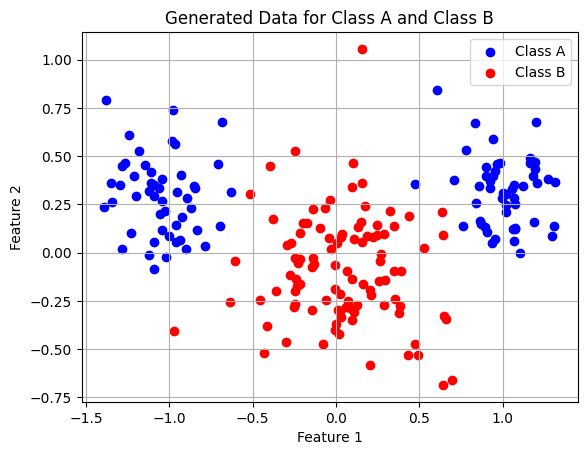

In [133]:
n = 100
mA = np.array([1.0, 0.3])
mB = np.array([0.0, -0.1])
sigmaA = 0.2
sigmaB = 0.3
half_1 = np.random.randn(int(np.round(0.5*n)),1) * sigmaA - mA[0]
half_2 = np.random.randn(int(np.round(0.5*n)),1) * sigmaA + mA[0]
classA_0 = np.vstack((half_1, half_2))
classA_1 = np.random.randn(n,1) * sigmaA + mA[1]
classA = np.hstack((classA_0, classA_1))
classB = np.random.randn(n, 2) * sigmaB + mB

plt.scatter(classA[:, 0], classA[:, 1], color='blue', label='Class A')
plt.scatter(classB[:, 0], classB[:, 1], color='red', label='Class B')
plt.title('Generated Data for Class A and Class B')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

In [134]:
def forward_pass(w, v, X):
  '''Hidden layer'''
  ones = np.ones(X.shape[1]).reshape((1, X.shape[1]))
  # print(X.shape,ones.shape)
  X_in = np.vstack((X, ones))
  # print(X_in, X_in.shape)
  h_in = np.dot(w,X_in) # (hidden,2n)
  # print(h_in, h_in.shape)
  h_out = transfer_function(h_in) #(hidden, 2n)
  # print(h_out, h_out.shape)
  '''Output layer'''
  H = np.vstack((h_out, ones))
  # print(H, H.shape)
  o_in = np.dot(v,H)
  # print(o_in, o_in.shape)
  o_out = transfer_function(o_in)
  # print(o_out, o_out.shape)
  return h_in, h_out, o_in, o_out, X_in, H

def backward_pass(h_in, h_out, o_in, o_out, t, v):
  phi_dot_o = der_transfer_function(o_in)
  delta_o = np.multiply((o_out - t), phi_dot_o)
  # print(delta_o, delta_o.shape)
  phi_dot_h = der_transfer_function(h_in)
  delta_h = np.multiply((np.dot(np.transpose(v[:,:-1]),delta_o)),phi_dot_h) # WE DON'T USE THE BIAS COLUMN FROM THE V MATRIX!!!
  # print(delta_h, delta_h.shape)
  return delta_o, delta_h

def backprop(classA_train, classB_train, hidden_dim, classA_val=None, classB_val=None, ):

  X_train = np.vstack((classA_train, classB_train))
  t_train = np.hstack((-np.ones(classA_train.shape[0]), np.ones(classB_train.shape[0])))
  perm = np.random.permutation(X_train.shape[0])
  X_train, t_train = X_train[perm], t_train[perm]
  X_train = np.transpose(X_train) # (2,2n)
  t_train = np.transpose(t_train) # (1,2n)

  '''
  If validation data is provided, use it. Otherwise,
  we reuse training data for validation.
  '''
  if classA_val is not None and classB_val is not None:
    X_val = np.vstack((classA_val, classB_val))
    t_val = np.hstack((-np.ones(classA_val.shape[0]), np.ones(classB_val.shape[0])))
    perm = np.random.permutation(X_val.shape[0])
    X_val, t_val = X_val[perm], t_val[perm]
    X_val = np.transpose(X_val) # (2,2n)
    t_val = np.transpose(t_val) # (1,2n)
  else:
    X_val = X_train
    t_val = t_train

  w_history = []
  v_history = []
  classification_accuracy_history = []
  mse_history = []
  w = np.random.random((hidden_dim,3)).reshape(hidden_dim,3) #(hidden, 2+bias)
  v = np.random.random((nodes_output_layer, hidden_dim+1)).reshape(nodes_output_layer,hidden_dim+1) #(output, hidden+bias)
  # print(f'W: {w}, {w.shape}')
  # print(f'V: {v}, {v.shape}')
  delta_w = 0
  delta_v = 0
  for _ in range(number_epochs):
    '''1st: FORWARD PASS: Activities of the nodes are computed layer for layer'''
    h_in, h_out, o_in, o_out, X_bias, H_bias = forward_pass(w, v, X_train)
    ''' 2nd: BACKWARD PASS: Error signal (delta) computed for each node'''
    delta_o, delta_h = backward_pass(h_in, h_out, o_in, o_out, t_train, v)
    ''' 3rd: WEIGHT UPDATE'''
    delta_w = delta_w*alpha - (1-alpha)*np.dot(delta_h, np.transpose(X_bias))
    delta_v = delta_v*alpha - (1-alpha)*np.dot(delta_o, np.transpose(H_bias))
    # print(delta_v)
    w += learning_rate*delta_w
    v += learning_rate*delta_v
    # print(v)
    classification_accuracy_history.append(check_accuracy(w,v,X_val,t_val))
    mse_history.append(mse(w,v,X_val,t_val))
    w_history.append(w.copy())
    v_history.append(v.copy())
    #print(f'Epoch {_+1}/{number_epochs} - Accuracy: {accuracy*100:.2f}%')
  hidden_node_accuracy = check_accuracy(w,v,X_val,t_val)
  # print(v_history)
  return np.array(w_history), np.array(v_history), np.array(classification_accuracy_history), np.array(mse_history), hidden_node_accuracy


def check_accuracy(w,v,X,t):
  _, _, Z_data, _, _, _ = forward_pass(w, v, X)
  labels_pred = np.sign(Z_data).flatten()
  correct = 0
  for i in range(labels_pred.shape[0]):
      if labels_pred[i] == t[i]:
          correct += 1
  return correct / X.shape[1]

'''
Mean Squared Error accuracy function
Follows the formula: MSE = 1/N * sum((t - Z_data)^2) / 4
Note that we're dividing by 4 to account for worst case
scenario where t = 1 and Z_data = -1.
'''
def mse(w, v, X, t):
  _, _, Z_data, _, _, _ = forward_pass(w, v, X)
  labels_pred = np.sign(Z_data).flatten()
  return np.mean((t - labels_pred)**2) / 4

#### Hidden nodes effect

In [135]:
def plot_decision_boundary(epoch_idx, title, w_history, v_history, classA, classB, hidden_dim):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot data points
    ax.scatter(classA[:, 0], classA[:, 1], color='blue', label='Class A')
    ax.scatter(classB[:, 0], classB[:, 1], color='red', label='Class B')

    # Then we create the decision boundary line
    x_boundry = np.linspace(-3, 3, 100)
    w = np.array(w_history[epoch_idx]).reshape(hidden_dim,3)
    v = np.array(v_history[epoch_idx]).reshape(nodes_output_layer, hidden_dim+1)
    # print(w, w.shape)
    # print(v,v.shape)

    xx, yy = np.meshgrid(
    np.linspace(-2, 2, 400),
    np.linspace(-2, 2, 400)
          )
    X_grid = np.vstack([xx.ravel(), yy.ravel()])

    _, _, o_in, _, _, _ = forward_pass(w, v, X_grid)

    Z = o_in
    Z_plot = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z_plot, levels=50, cmap='coolwarm', alpha=0.4)
    plt.contour(xx, yy, Z_plot, levels=[0], colors='black', linewidths=2)

    '''OBSERVING BOUNDARIES FROM INPUT TO HIDDEN LAYER'''
    # for i in range(hidden_dim):
    #   y_boundry = - (w[i,0]/w[i,1]) * x_boundry - (w[i,2]/w[i,1])
    #   ax.plot(x_boundry, y_boundry, label=f"Decision boundary {i}")

    '''OBSERVING BOUNDARIES FROM INPUT TO OUTPUT LAYER'''
    # for i in range(nodes_output_layer):
    #   v_a = v[:,:-1]
    #   print(f"v_a: {v_a}, {v_a.shape}")
    #   const_1 = (np.dot(v_a[i,:],w[:,0])).T #Not necessary T
    #   const_2 = (np.dot(w[:,2].T,v_a[i,:]) + v[i,-1])
    #   const_den = (np.dot(v_a[i,:],w[:,1])).T #Not necessary T
    #   # print(const_2)
    #   y_boundry = - x_boundry *  const_1/const_den- const_2/const_den
    #   ax.plot(x_boundry, y_boundry, label=f"Decision boundary {i}")

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.legend()
    ax.set_title(title)


def plot_accuracy(mse_history, classification_accuracy_history, title, title_suffix=''):
    plt.figure(figsize=(8, 5))
    plt.plot(classification_accuracy_history, label='Classification Accuracy')
    plt.plot(mse_history, label='MSE')
    plt.title(title + " " + title_suffix)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()

def plot_node_accuracy(node_accuracy_history, title, title_suffix=''):
    plt.figure(figsize=(8, 5))
    plt.plot(node_accuracy_history, label='Accuracy')
    plt.title(title + " " + title_suffix)
    plt.xlabel('Number of hidden layer nodes')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()

In [136]:
def train_and_evaluate(classA_train, classB_train, classA_val=None, classB_val=None, title_suffix=''):
  desired_nodes_hidden_layer = 15
  hidden_node_accuracy_history = []
  for i in range(1, desired_nodes_hidden_layer+1):
    w_history, v_history, classification_accuracy_history, mse_history, hidden_node_accuracy= backprop(classA_train, classB_train, i, classA_val, classB_val)
    title = f'Backprop with two-layer perceptron network (Hidden layer: {i})'
    if classA_val is None and classB_val is None: #In order to plot something
      classA_plot = classA_train
      classB_plot = classB_train
    else:
      classA_plot = classA_val
      classB_plot = classB_val
    plot_decision_boundary(epoch_idx=number_epochs-1,
                          title=title,
                          w_history=w_history,
                          v_history=v_history,
                          classA=classA_plot,
                          classB=classB_plot,
                          hidden_dim=i)
    plot_accuracy(mse_history, classification_accuracy_history, title, title_suffix)
    hidden_node_accuracy_history.append(hidden_node_accuracy)
    # print(np.array(hidden_node_accuracy_history).shape)
  plot_node_accuracy(np.array(hidden_node_accuracy_history), f'Backdrop accuracy of two-layer perceptron network (Epoch:{number_epochs})')

In [137]:
'''
Split Data takes a list of data points and divides it
into two groups: training data and validation data,
based on a ration 0-1.
'''
def split_data(data, n_train):
    # Shuffle data identically each time
    np.random.seed(42)
    perm = np.random.permutation(data.shape[0])
    data = data[perm]
    # Calculate split
    n = data.shape[0] * n_train // 1
    n = int(n)
    train_data = data[:n]
    val_data = data[n:]
    return train_data, val_data

### All data for training and vadliation

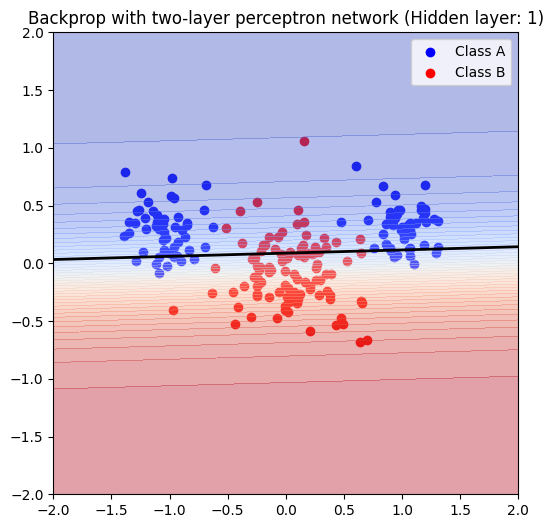

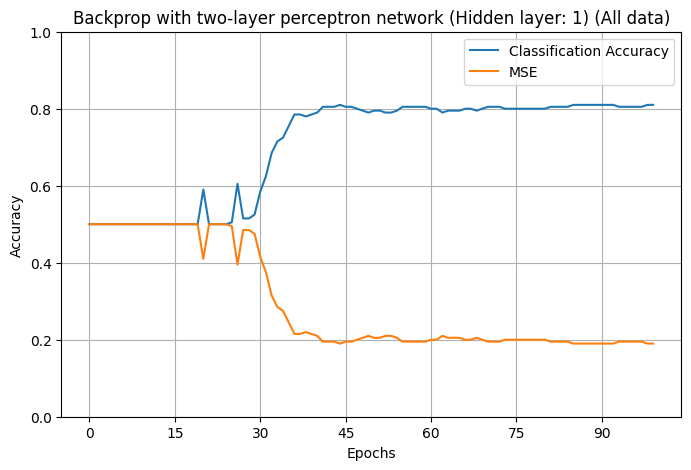

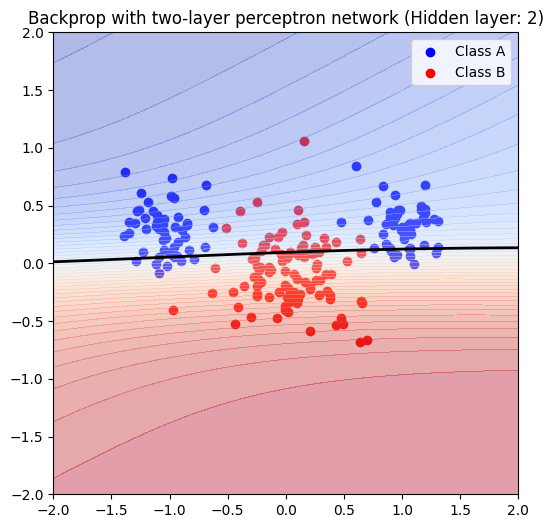

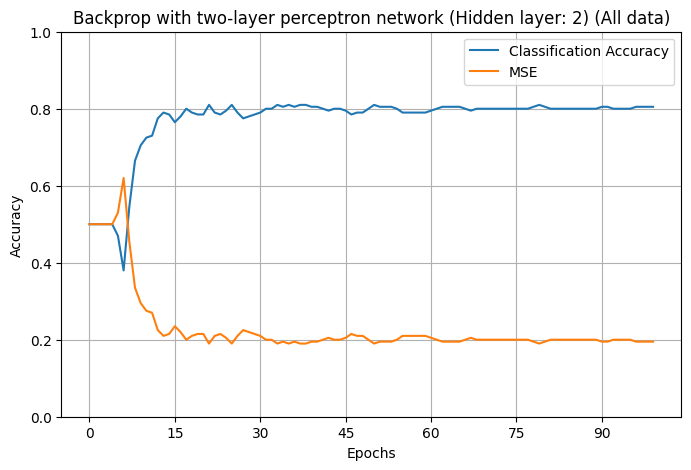

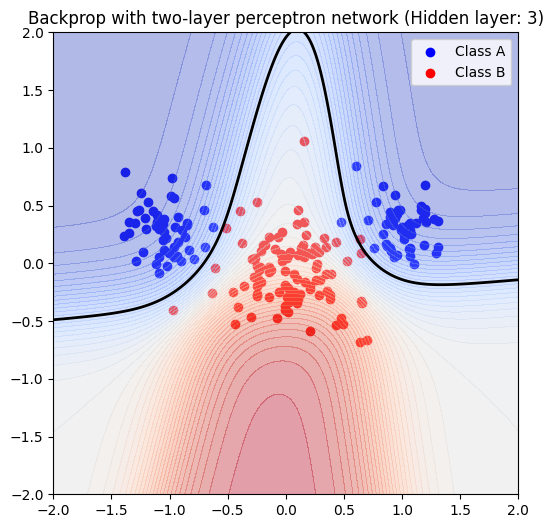

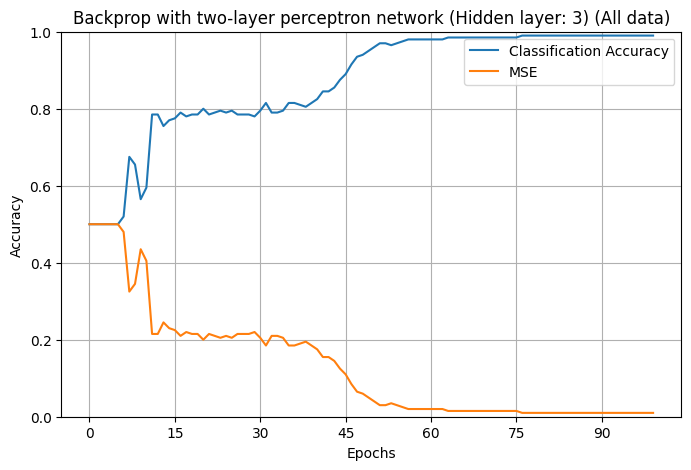

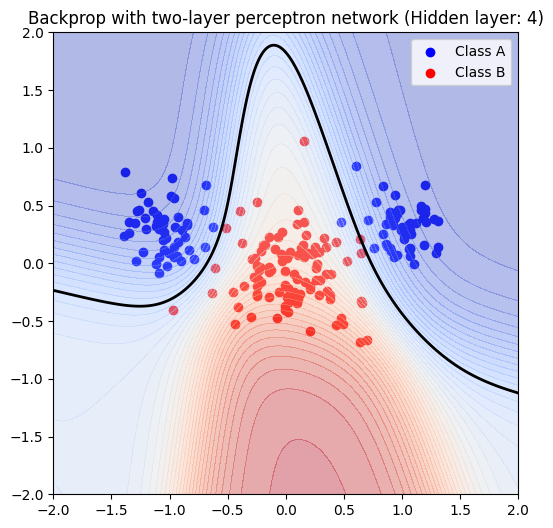

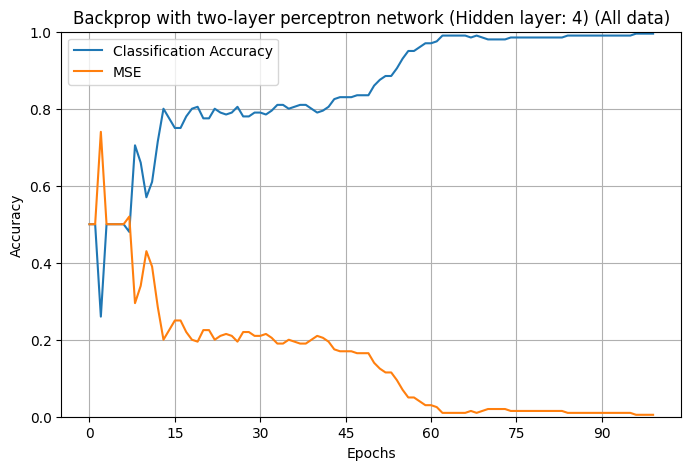

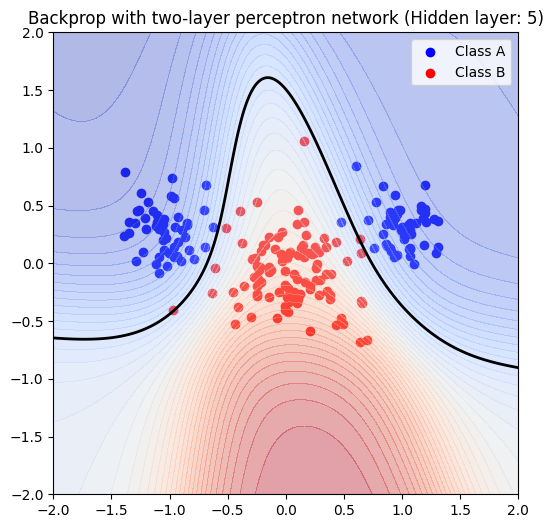

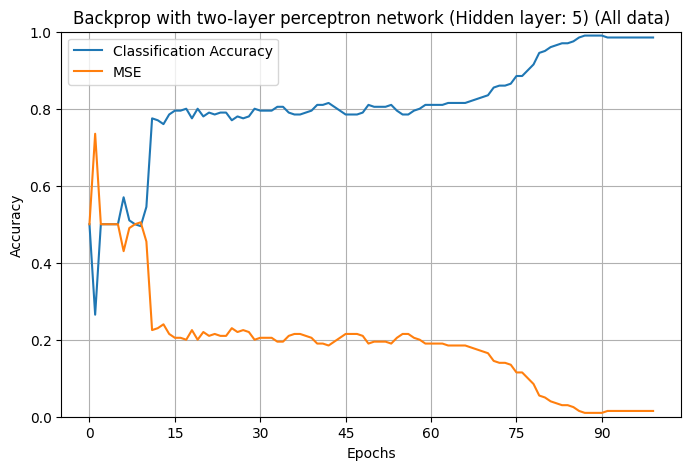

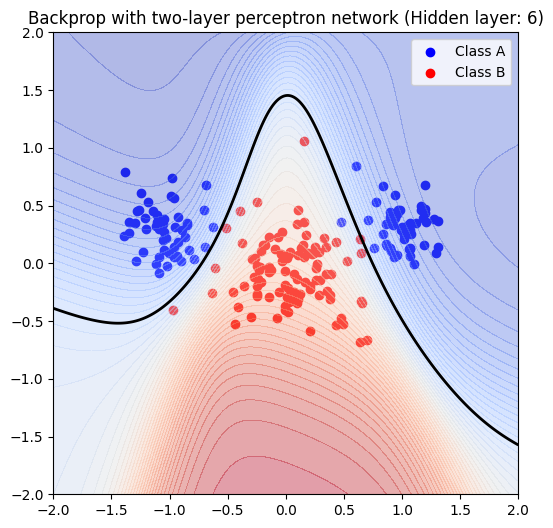

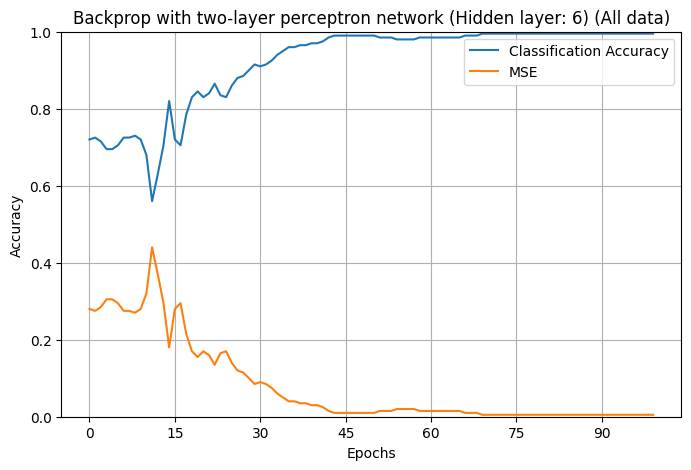

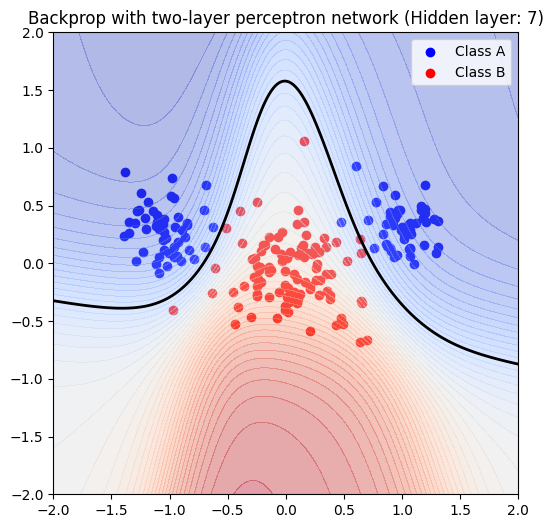

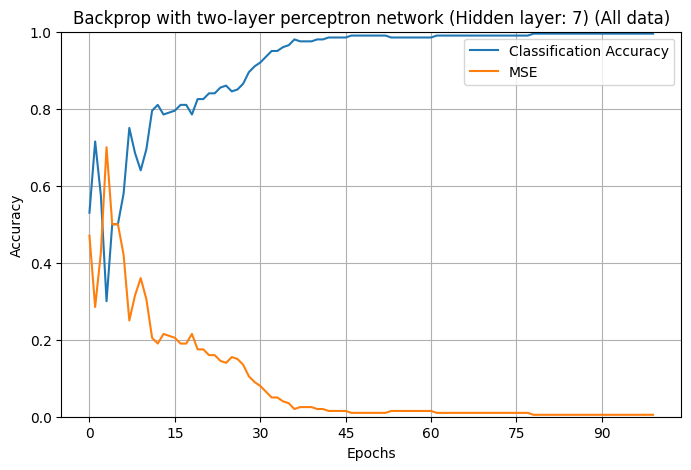

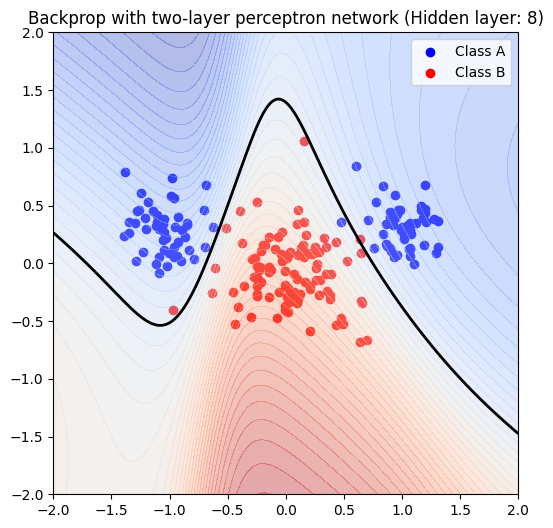

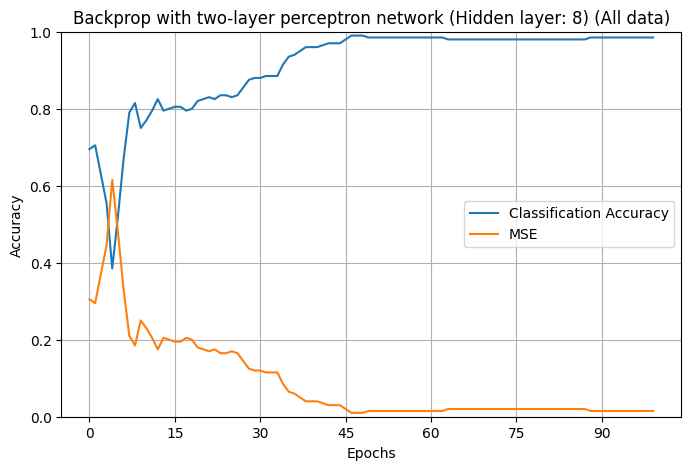

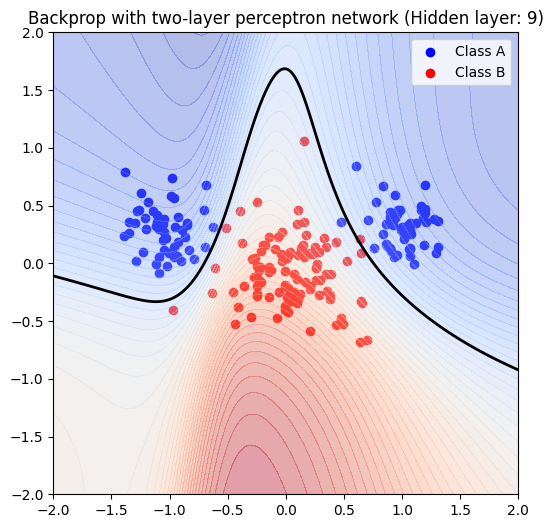

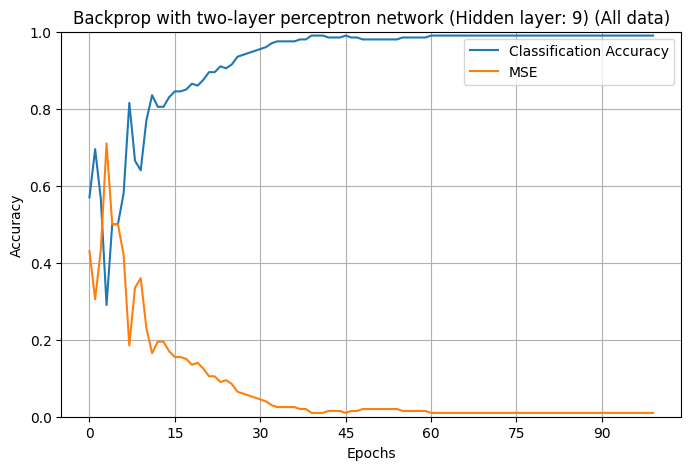

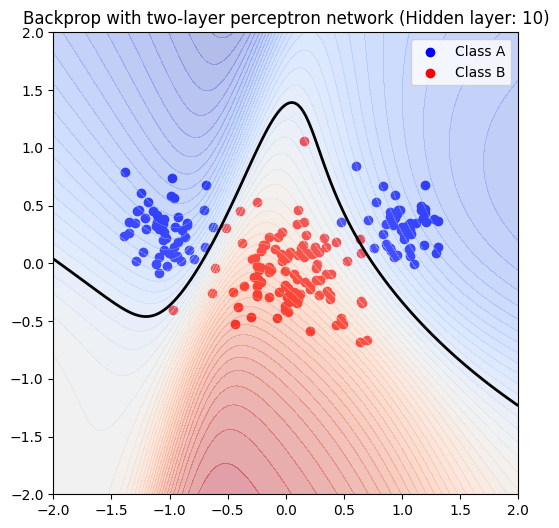

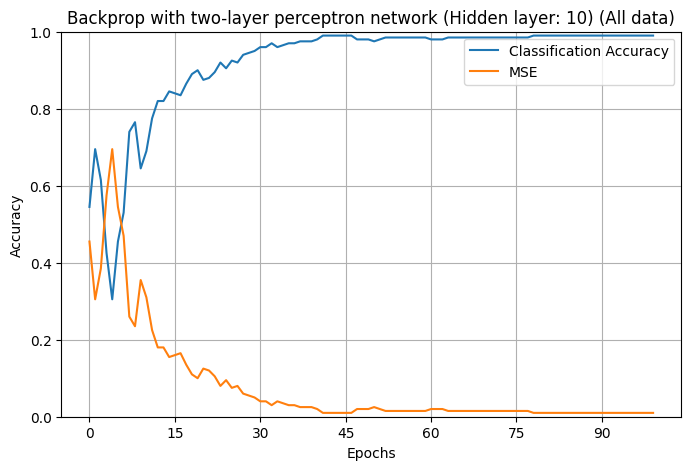

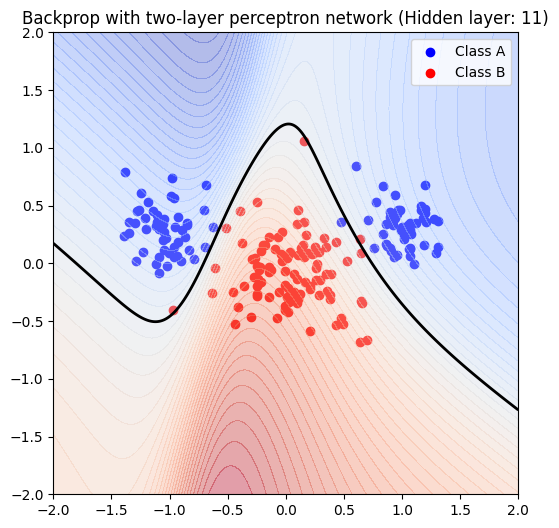

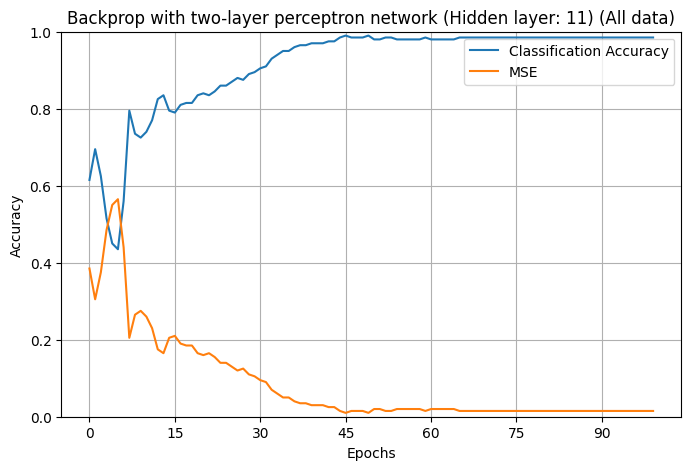

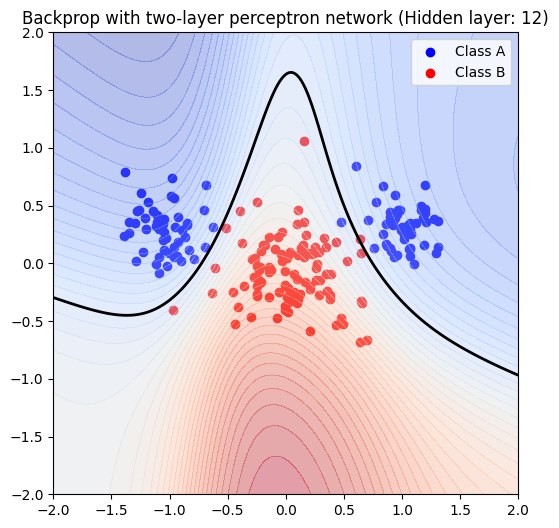

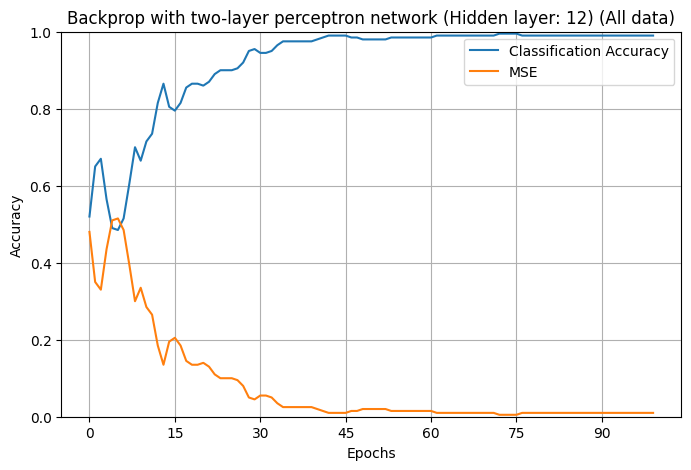

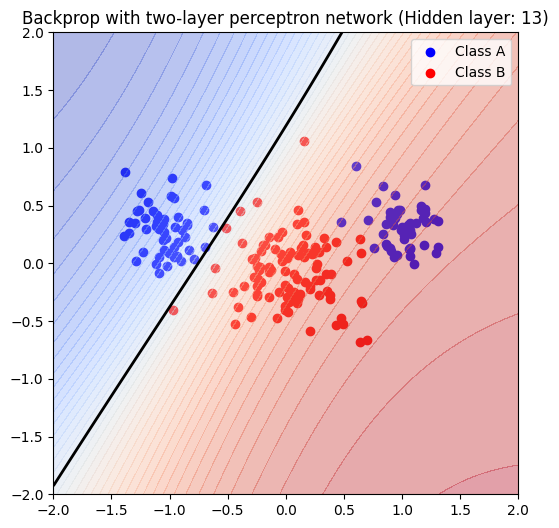

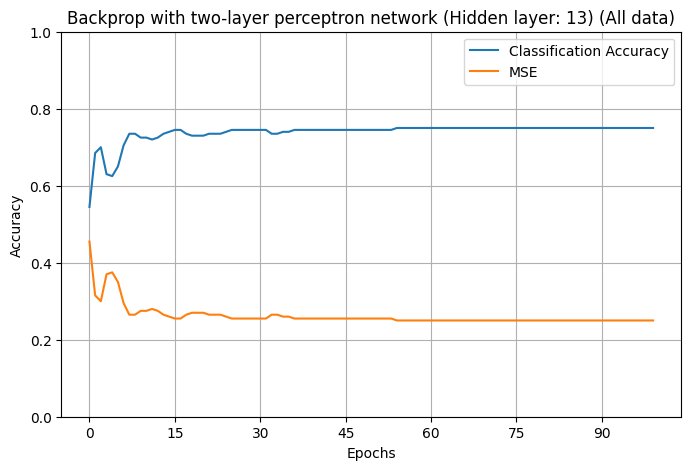

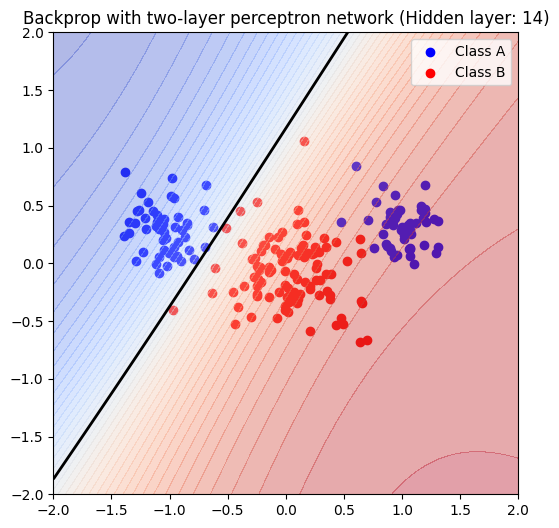

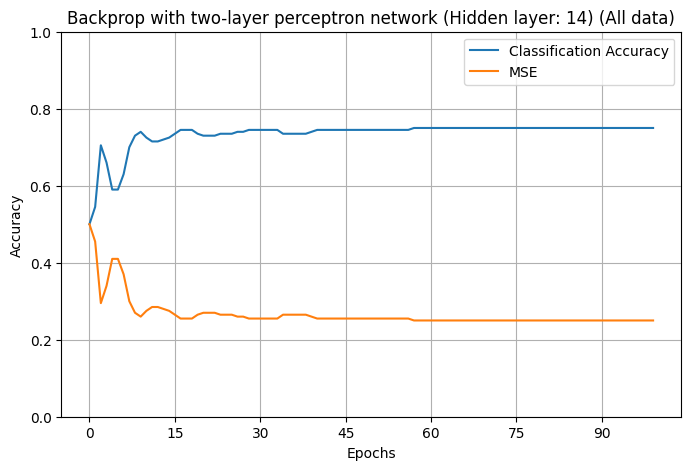

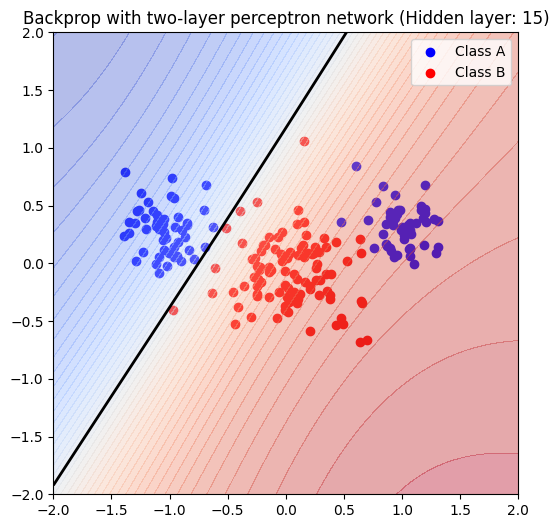

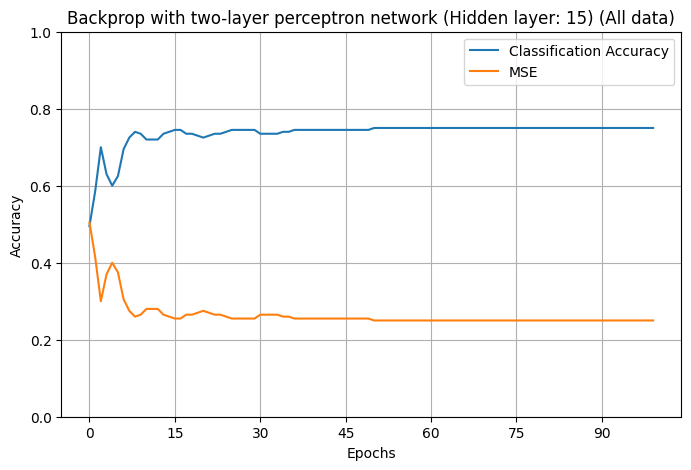

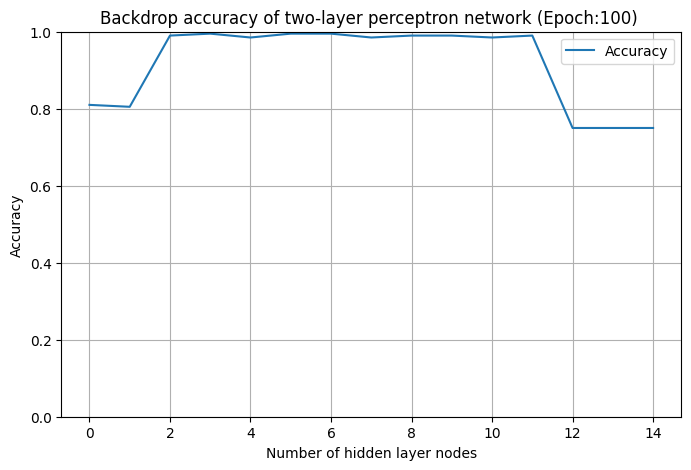

In [138]:
train_and_evaluate(classA, classB, title_suffix='(All data)')

### Random 75/25 split

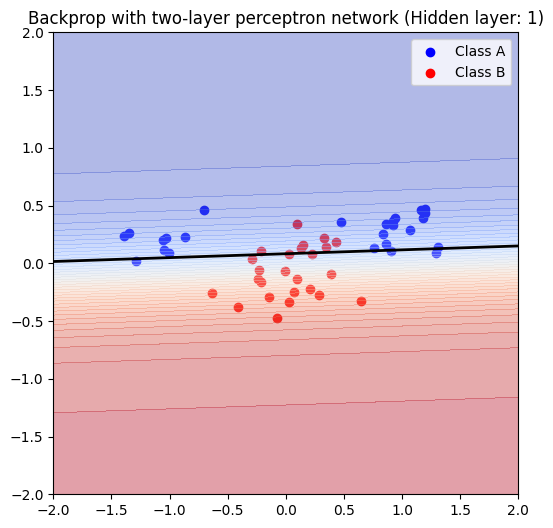

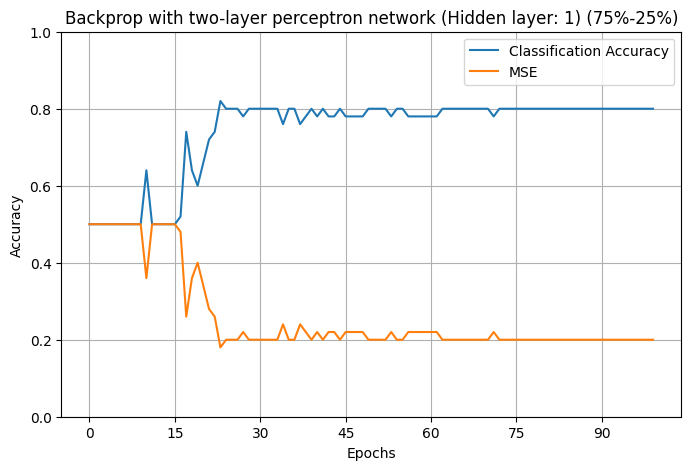

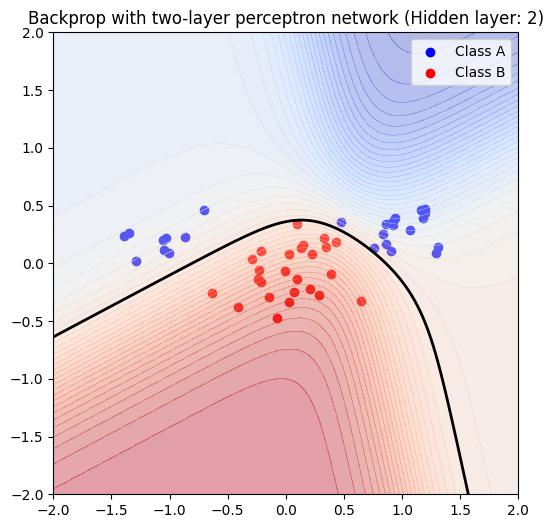

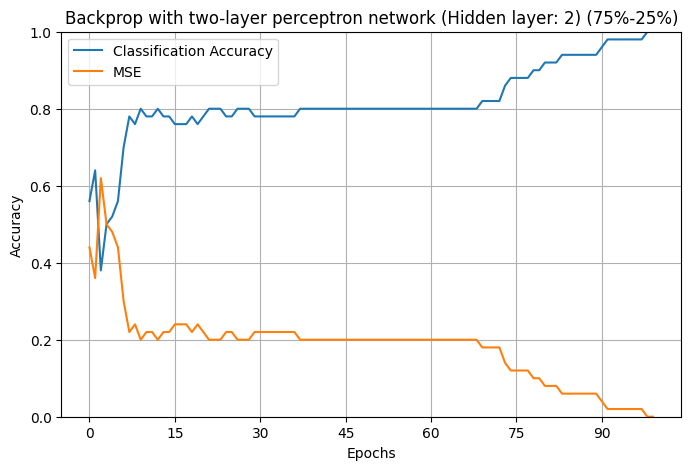

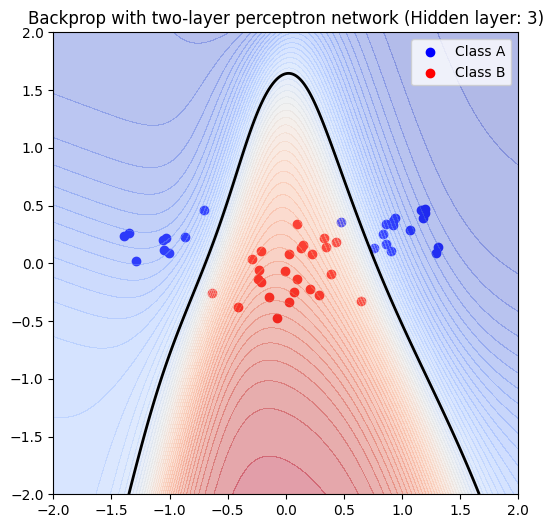

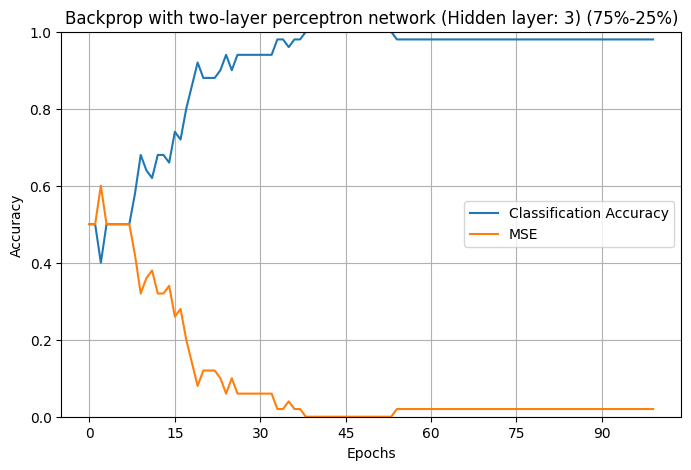

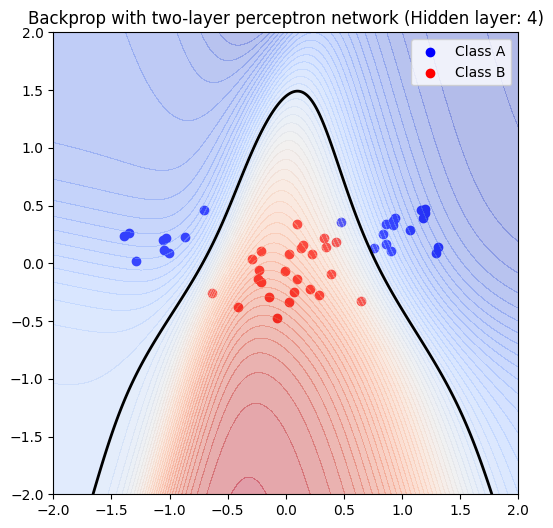

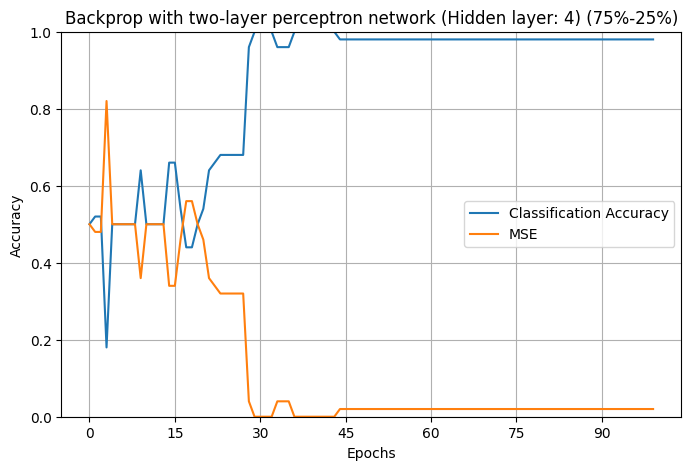

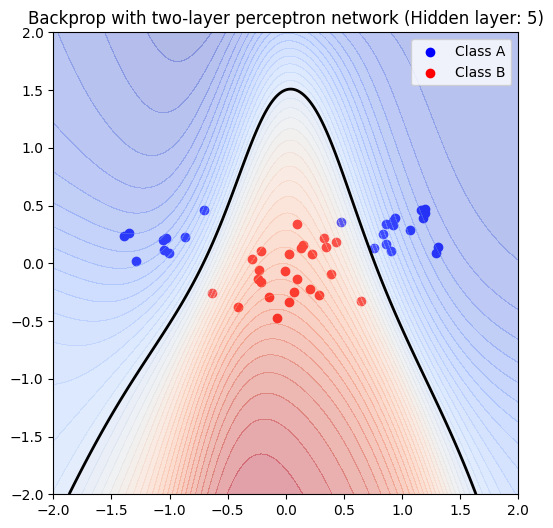

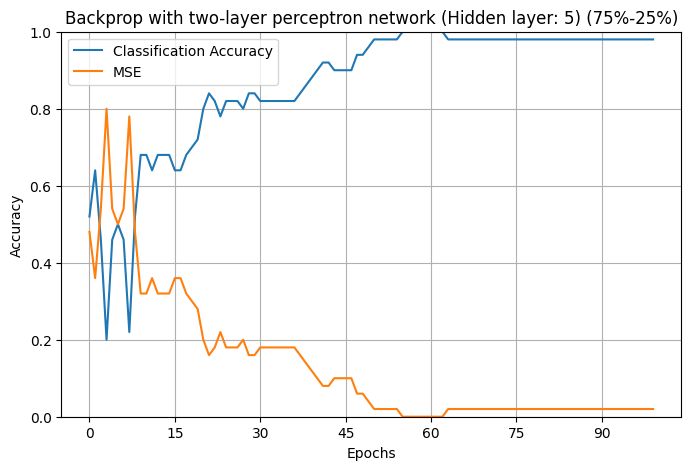

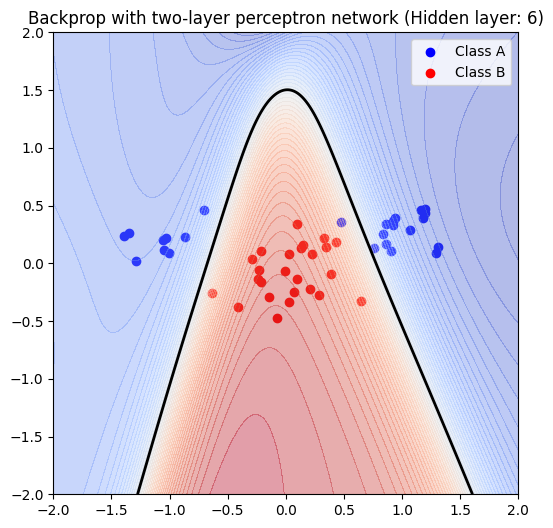

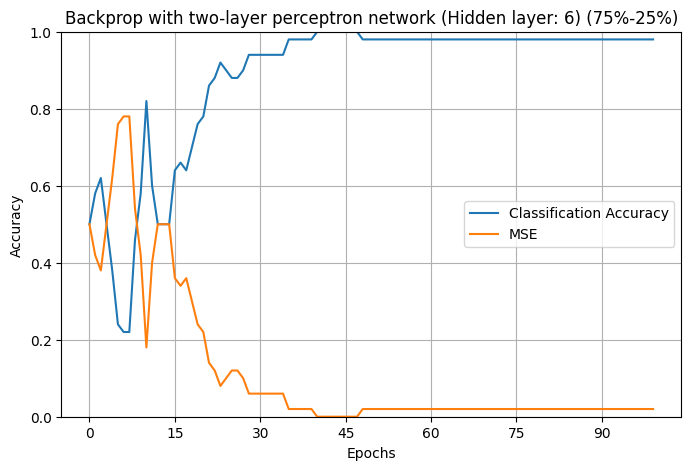

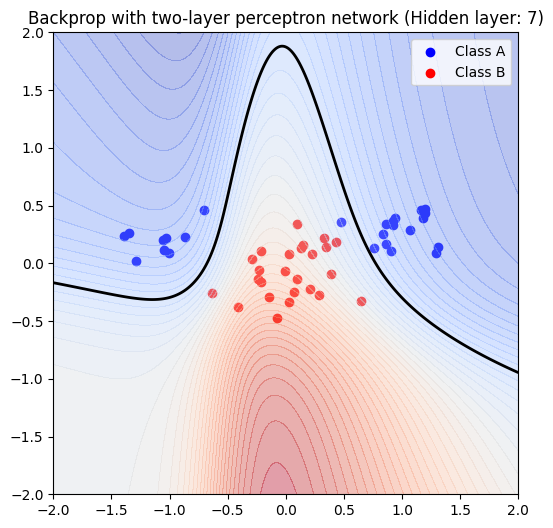

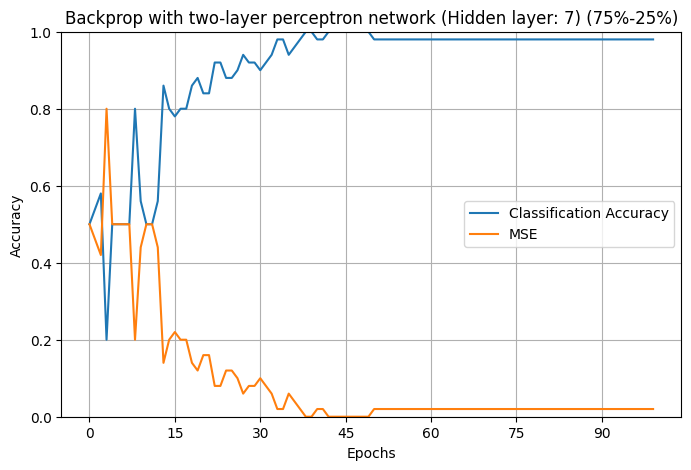

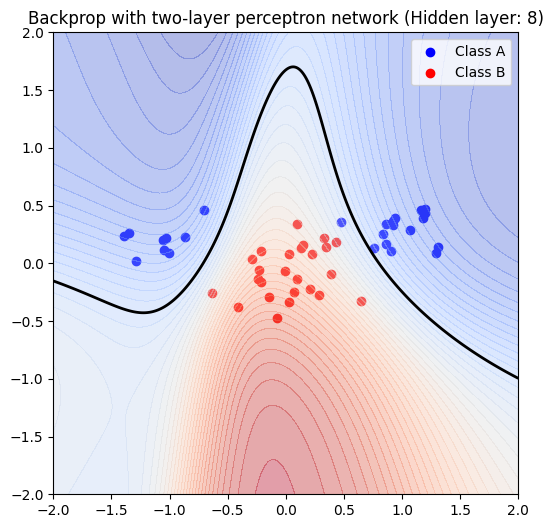

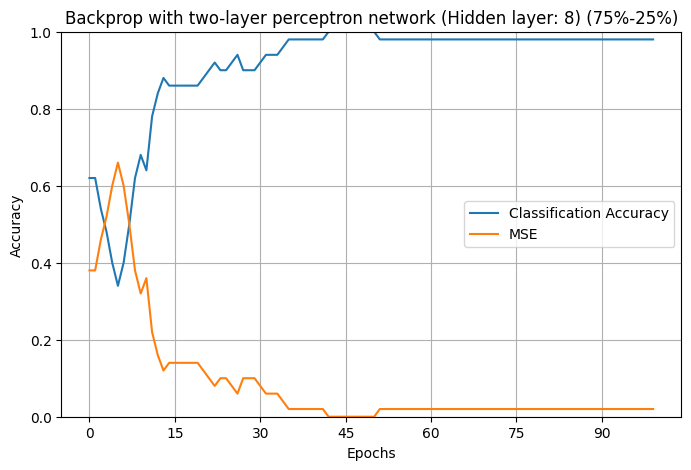

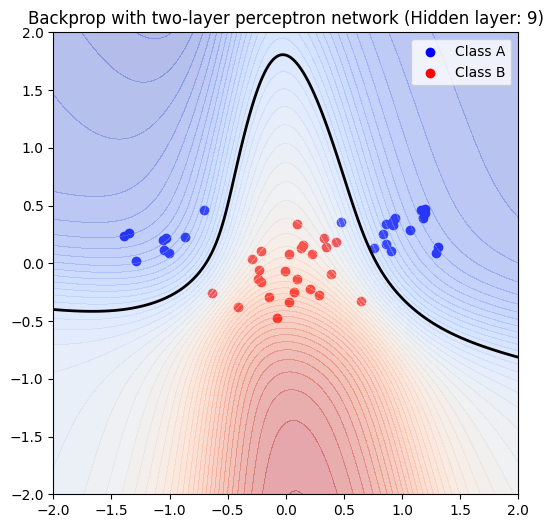

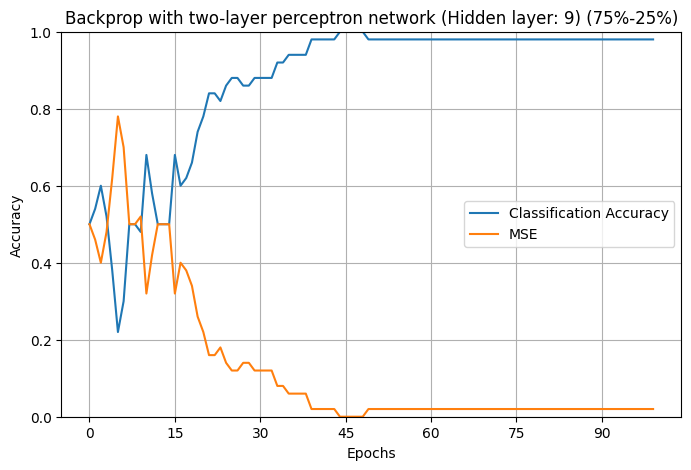

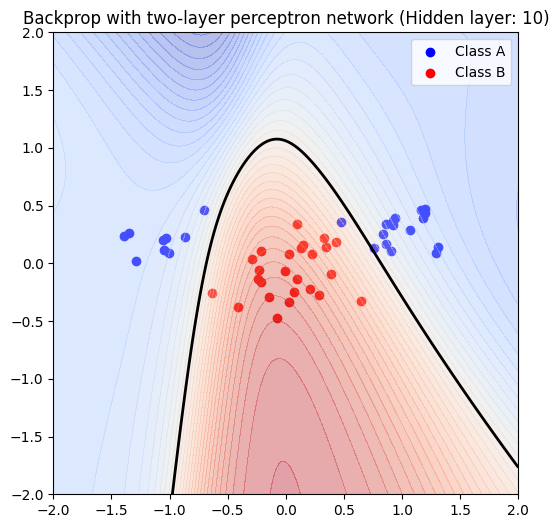

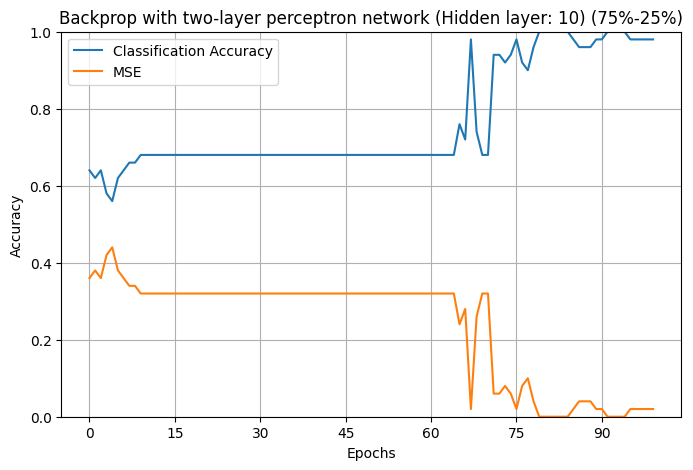

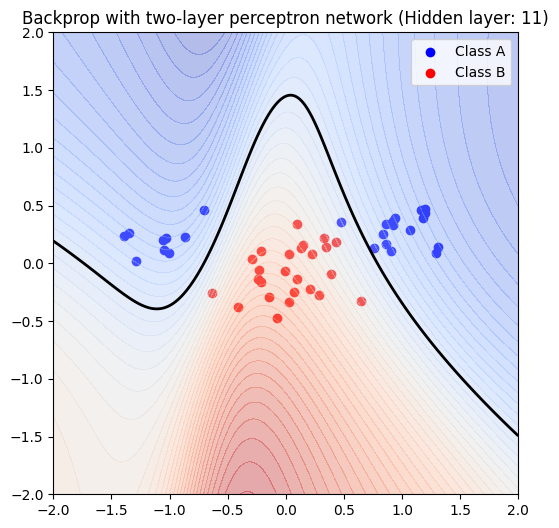

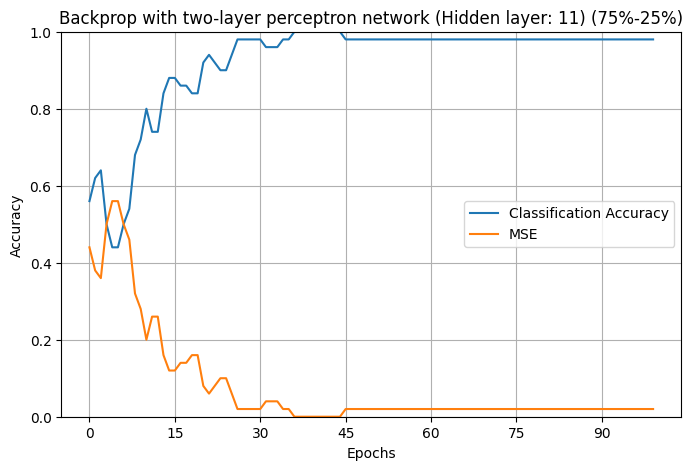

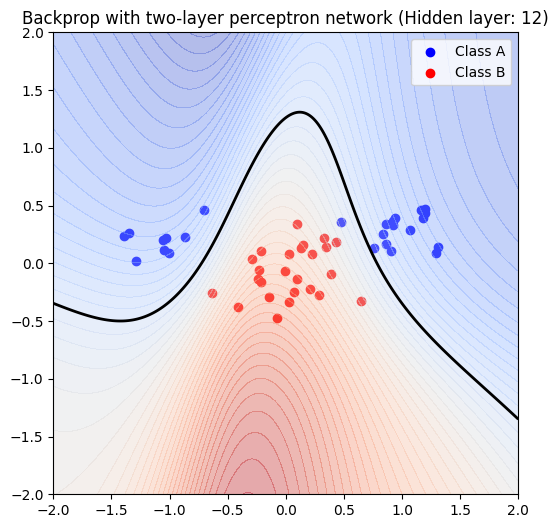

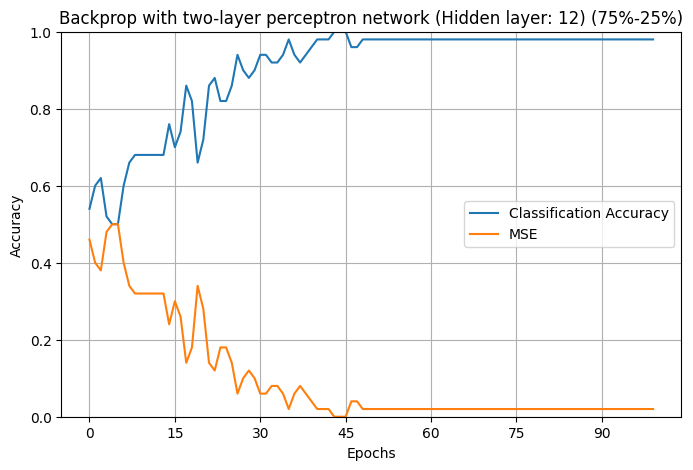

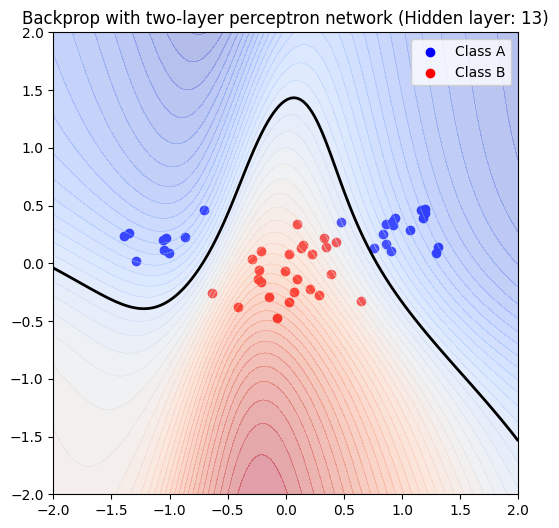

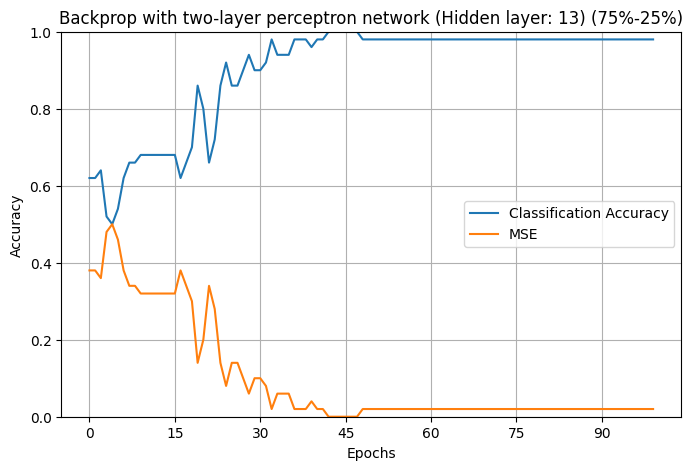

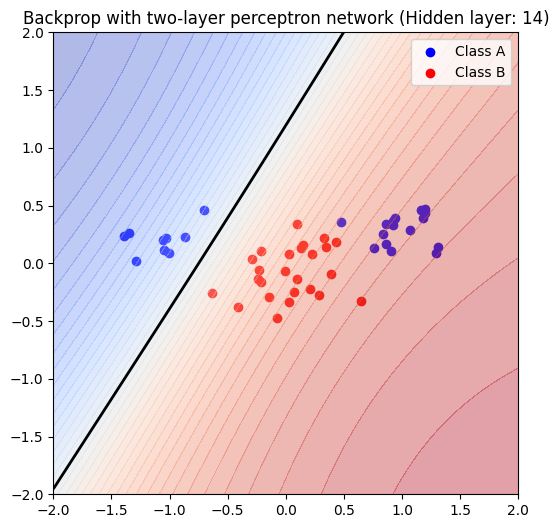

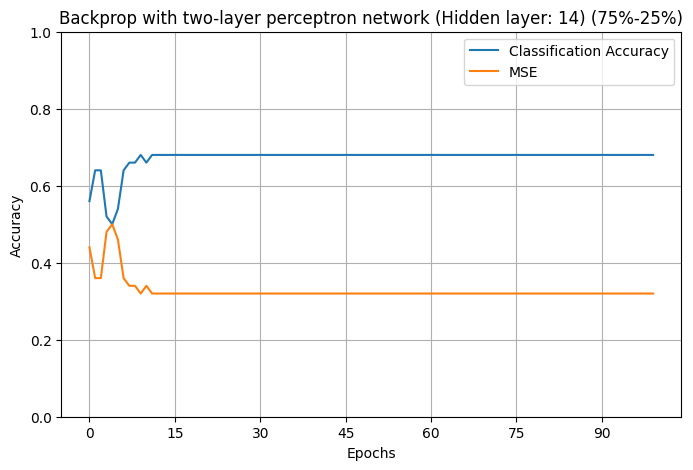

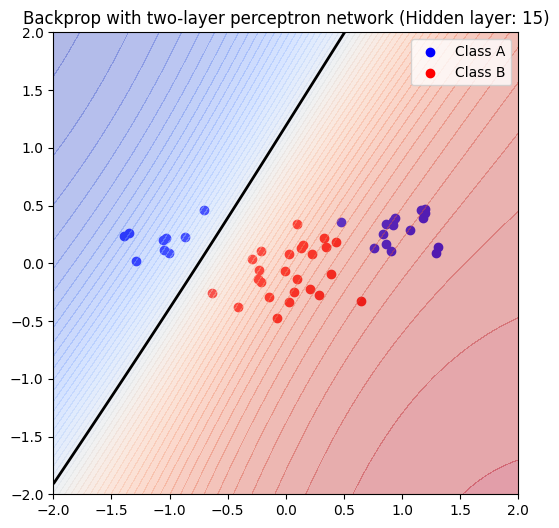

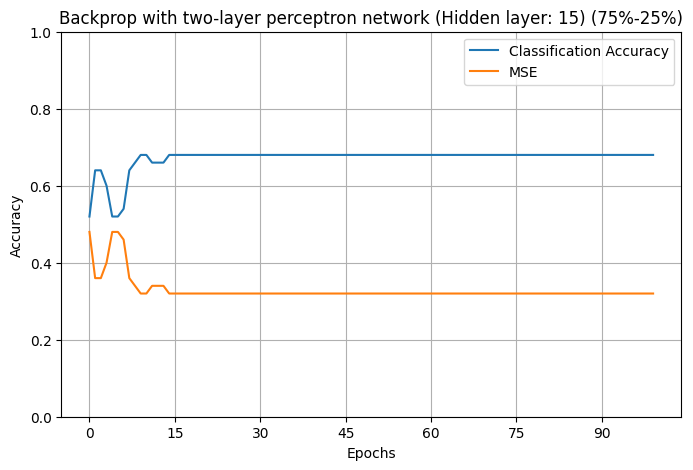

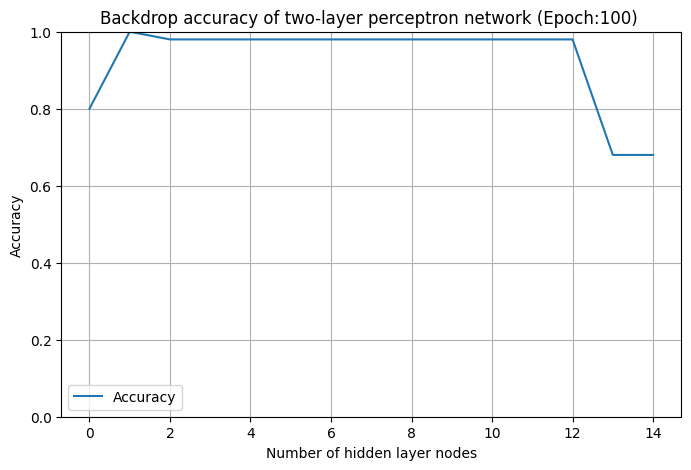

In [139]:
classA_train, classA_val = split_data(classA, 0.75)
classB_train, classB_val = split_data(classB, 0.75)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(75%-25%)')

### Random 50/50 split

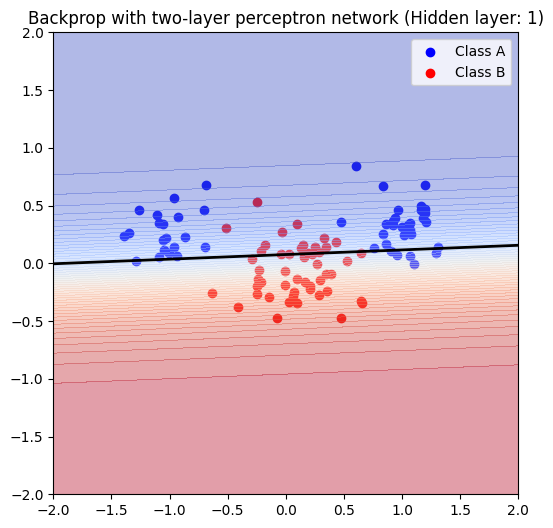

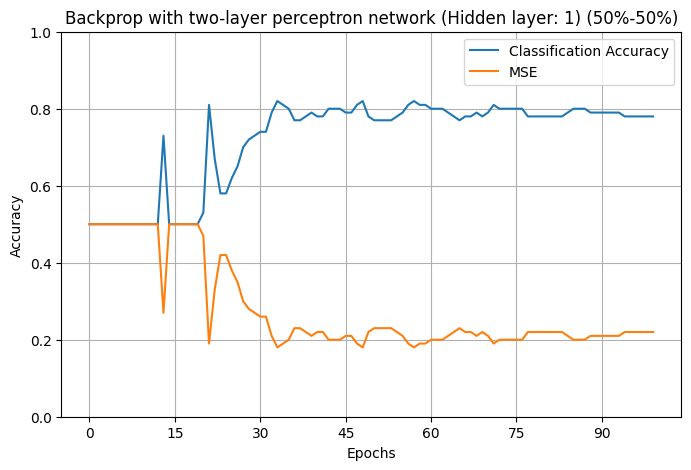

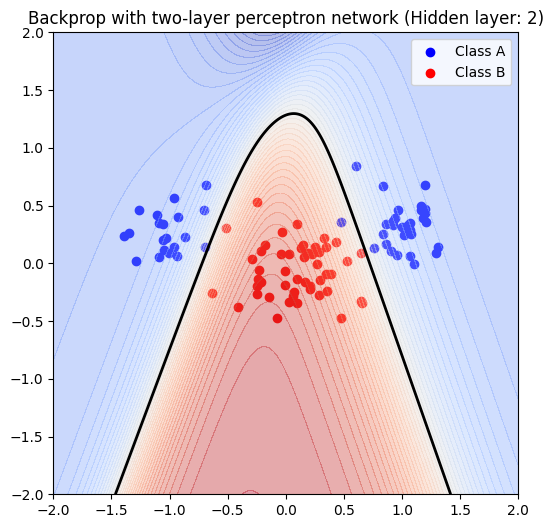

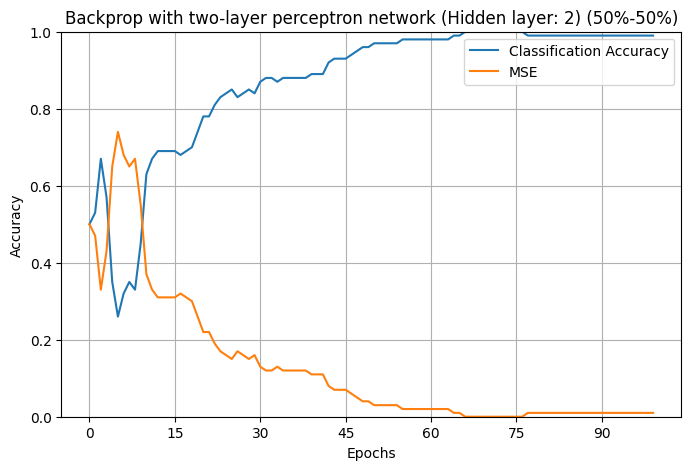

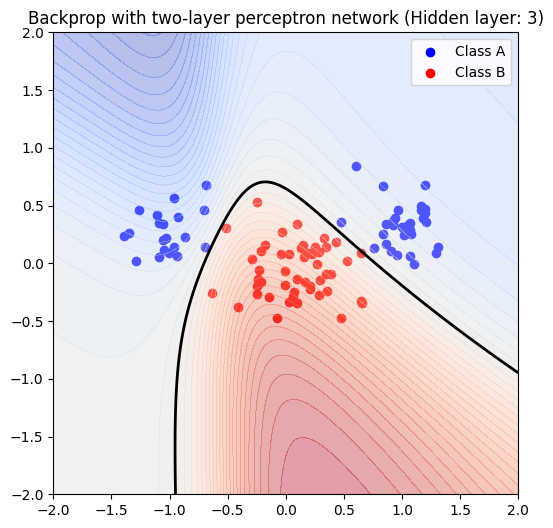

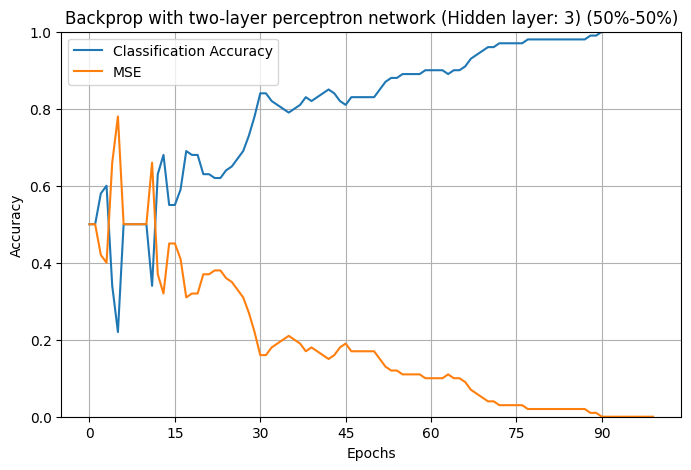

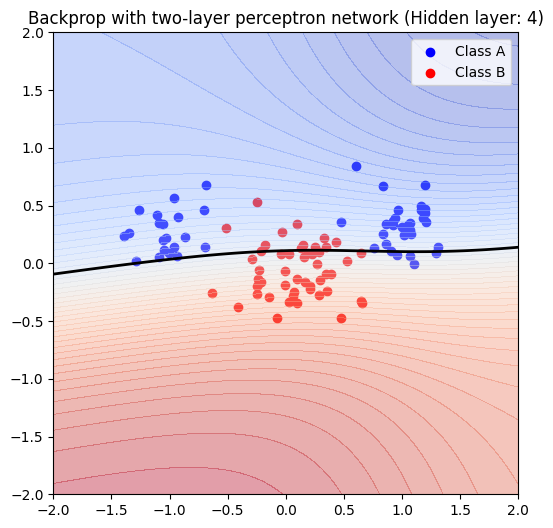

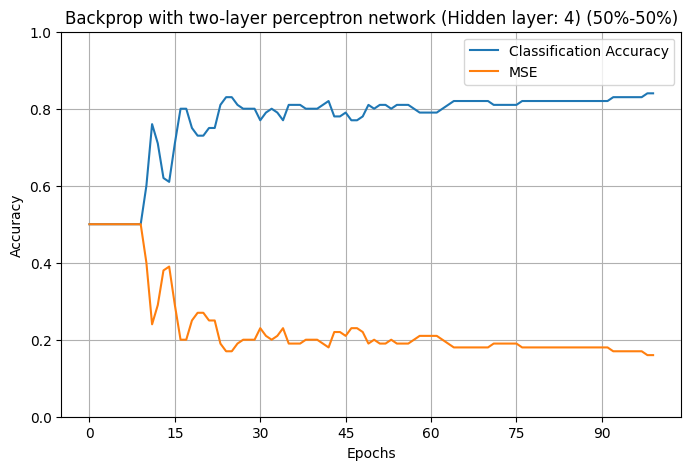

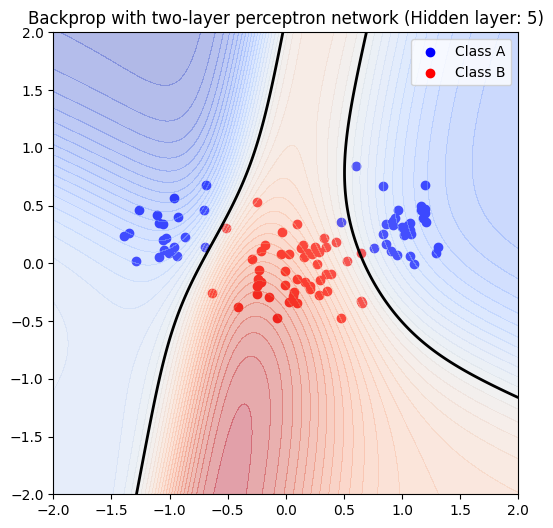

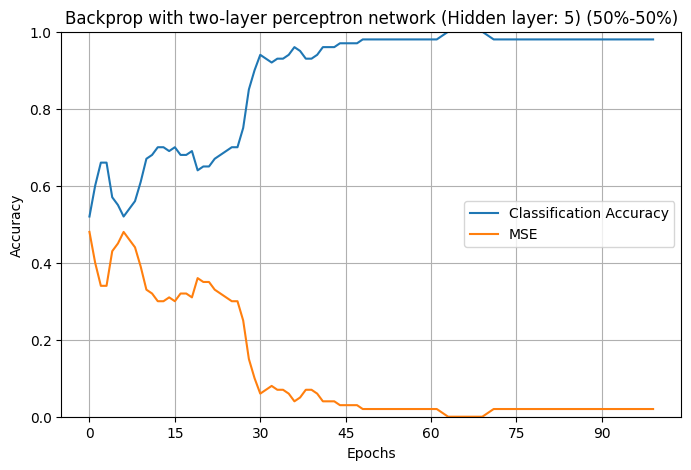

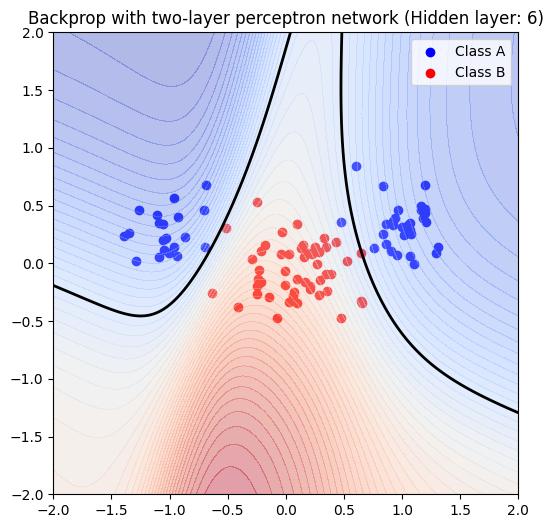

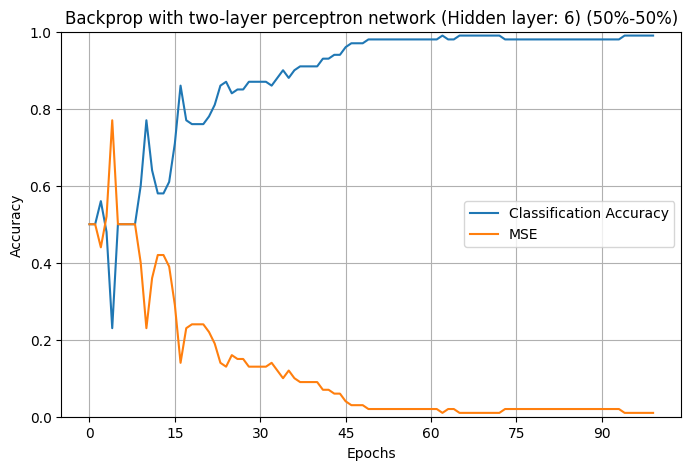

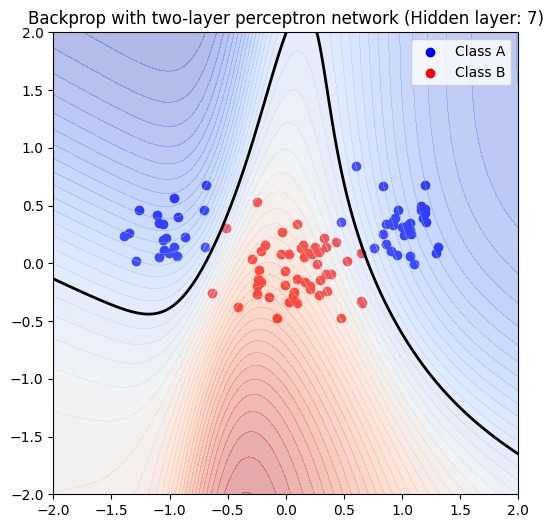

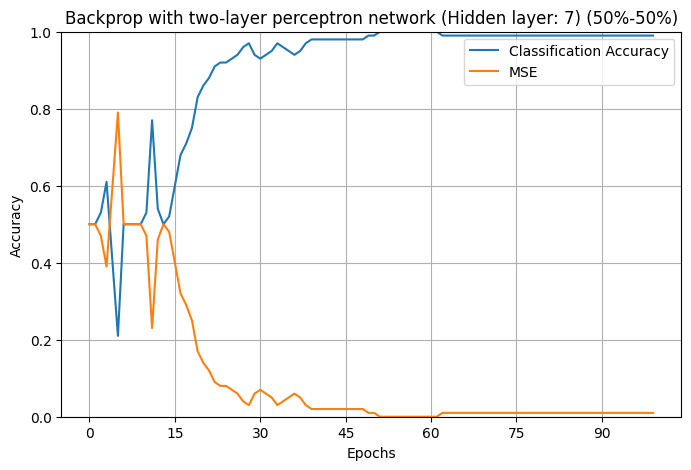

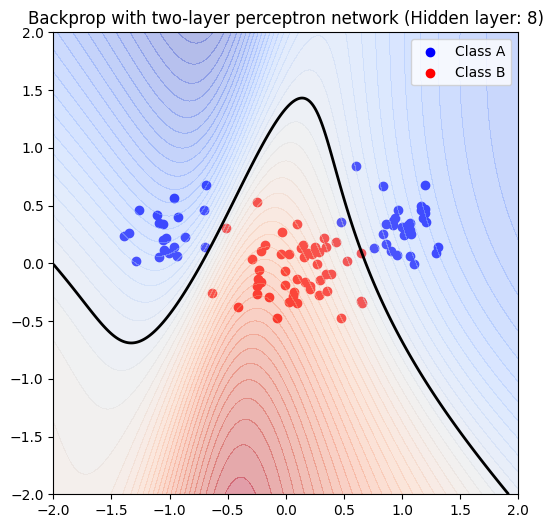

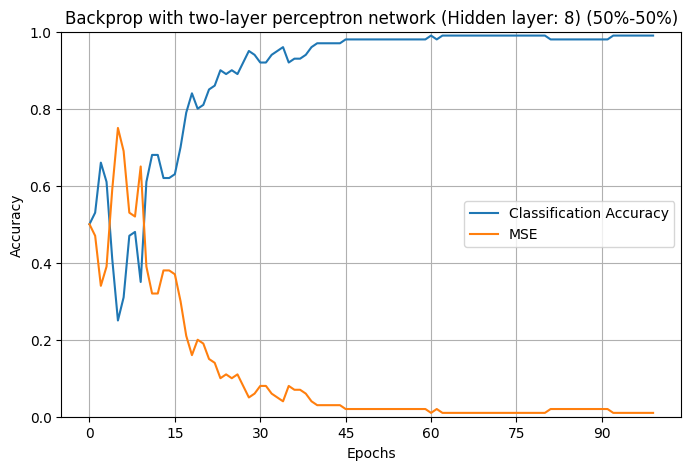

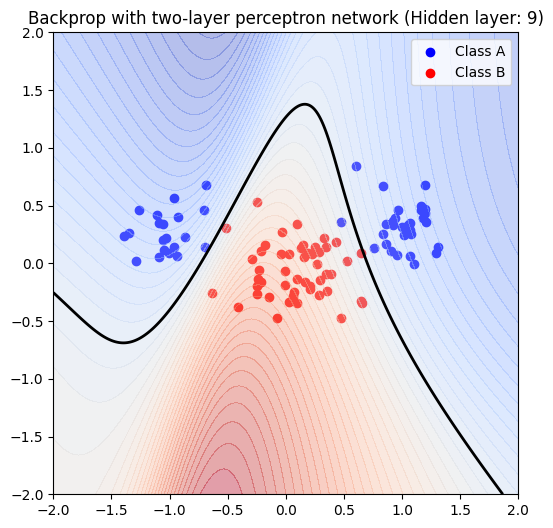

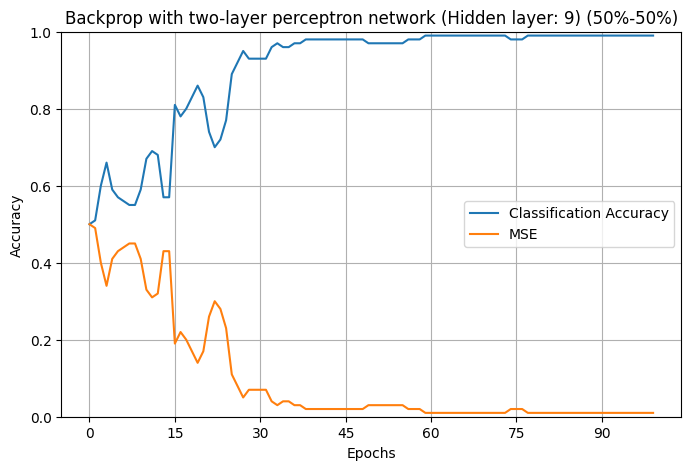

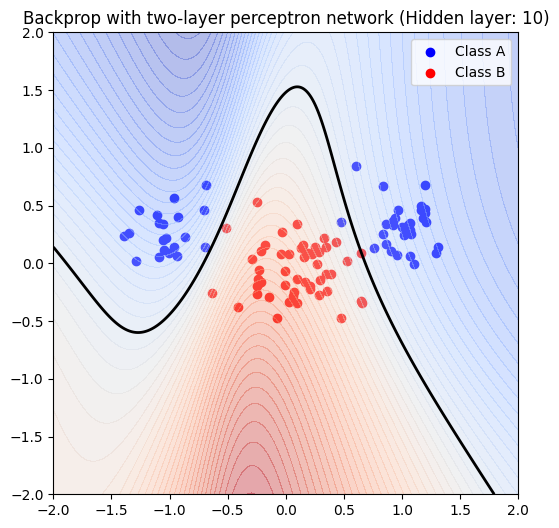

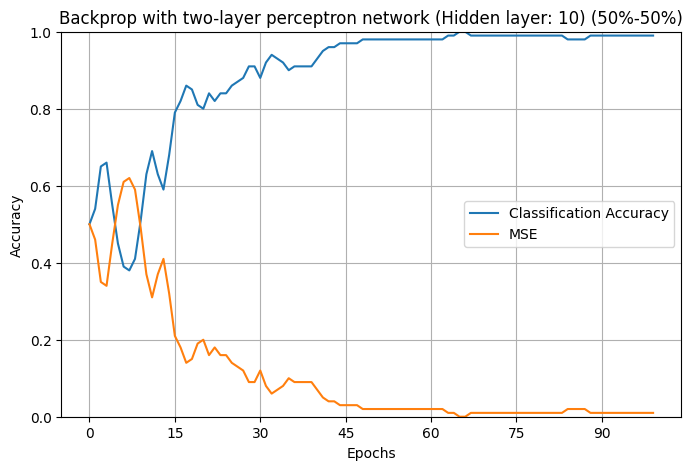

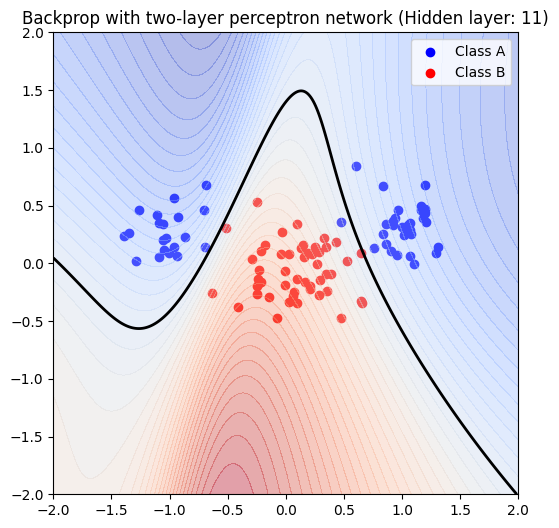

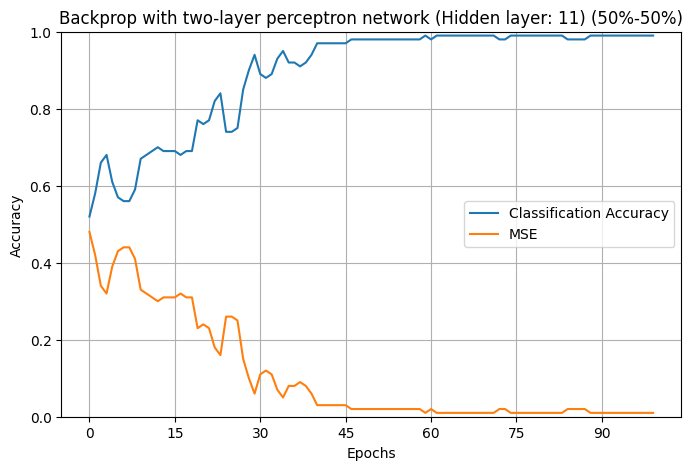

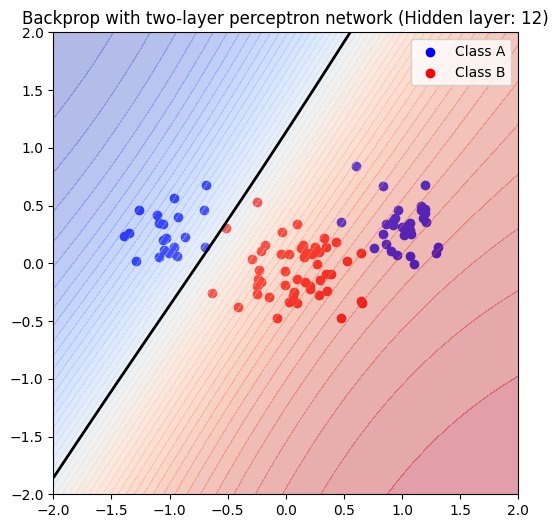

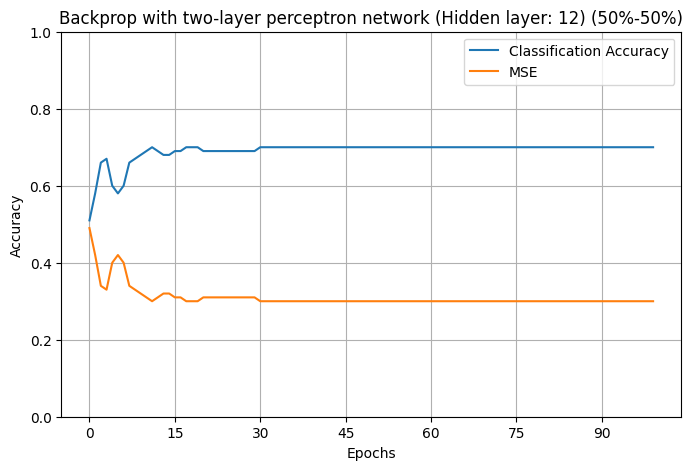

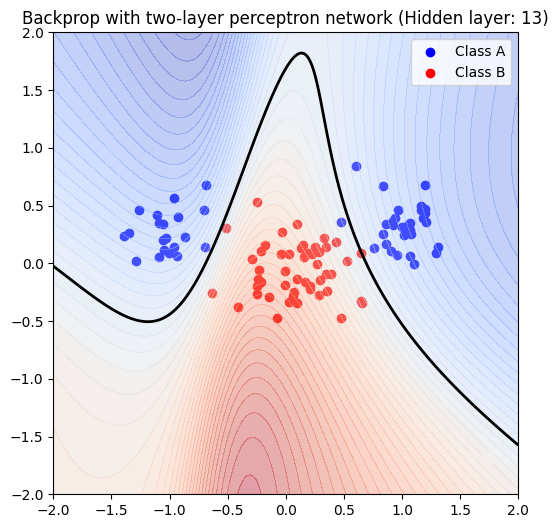

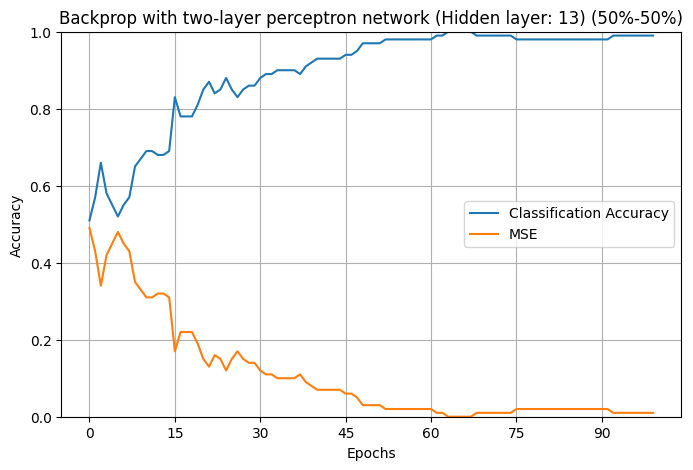

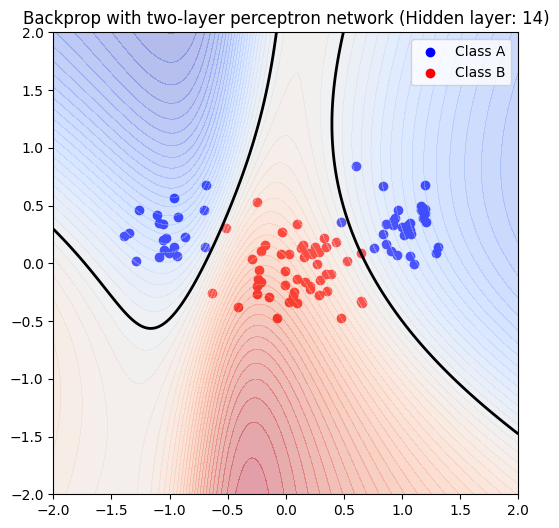

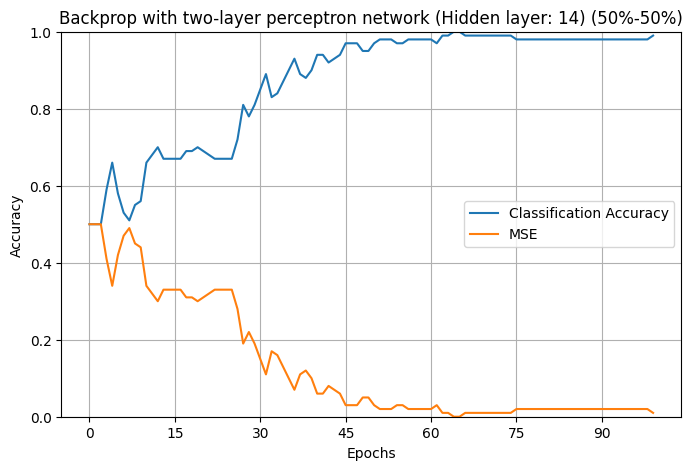

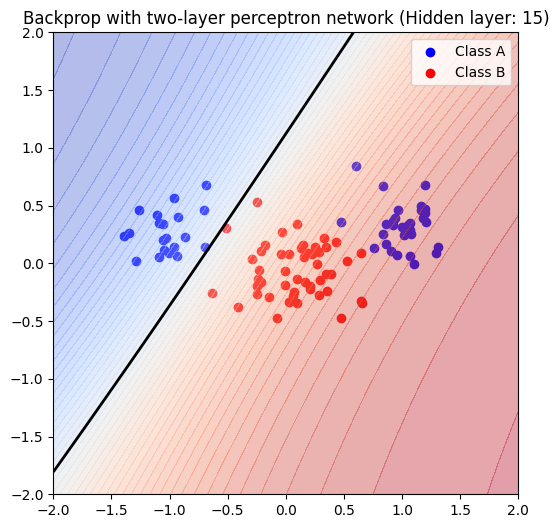

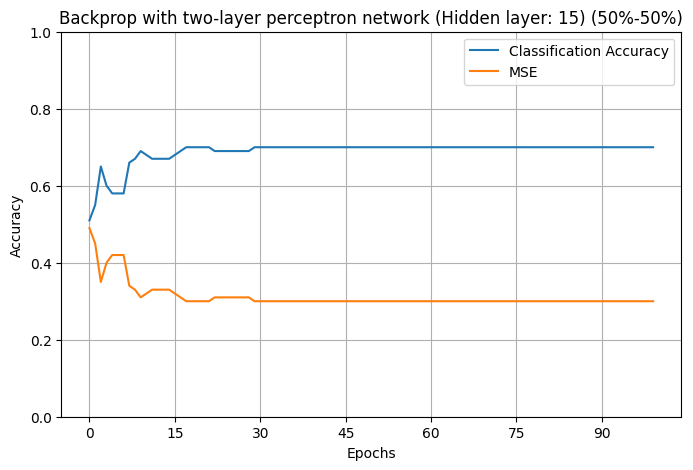

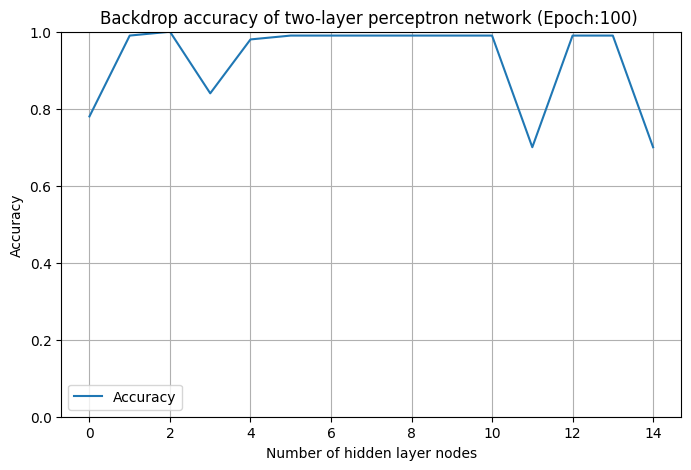

In [140]:
classA_train, classA_val = split_data(classA, 0.50)
classB_train, classB_val = split_data(classB, 0.50)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(50%-50%)')

### 20% from subset 1 of A and 80% form subset 2 of A

classA_train.shape: (50, 2)
classA_val.shape: (50, 2)


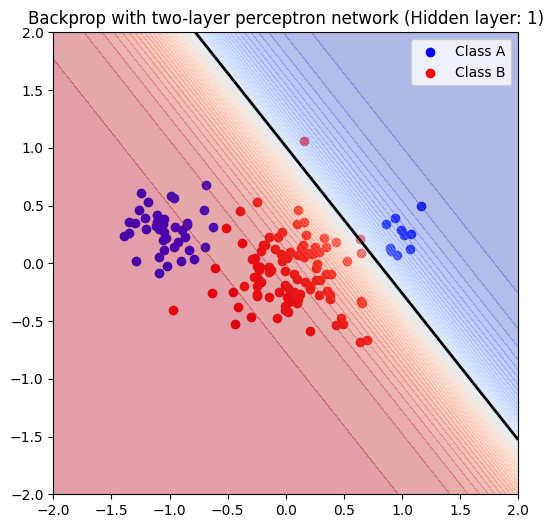

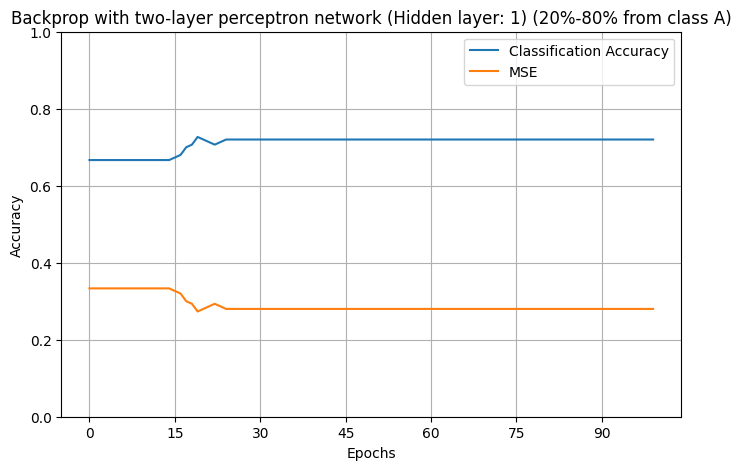

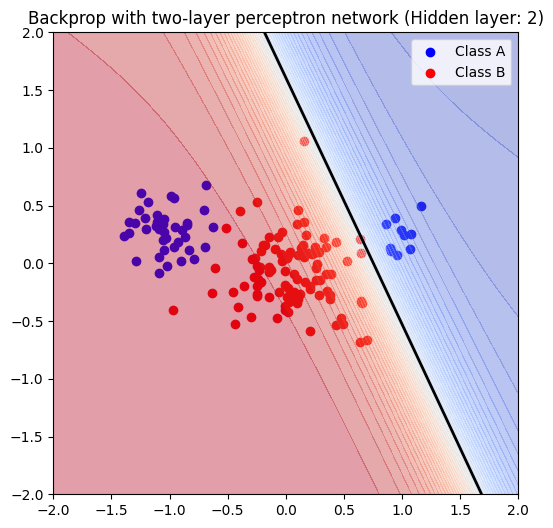

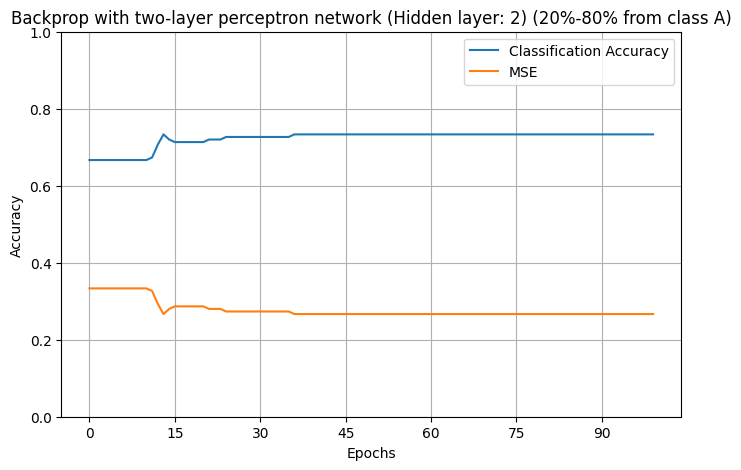

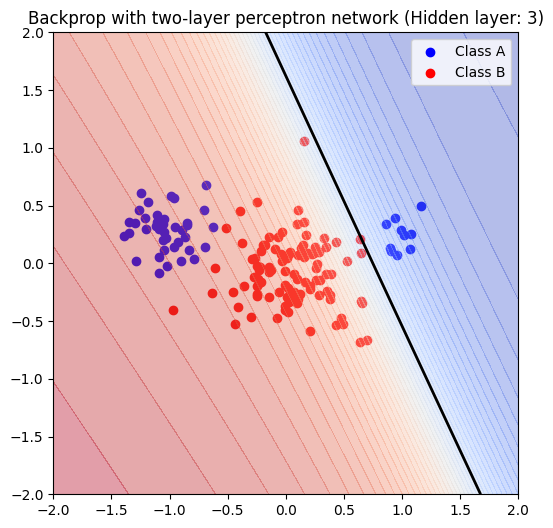

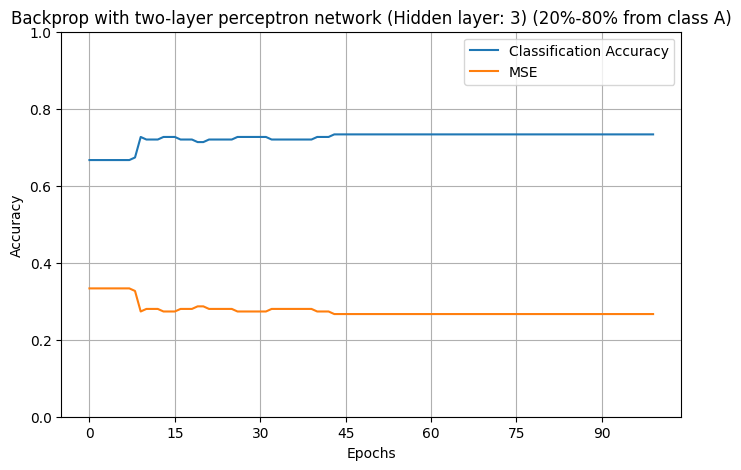

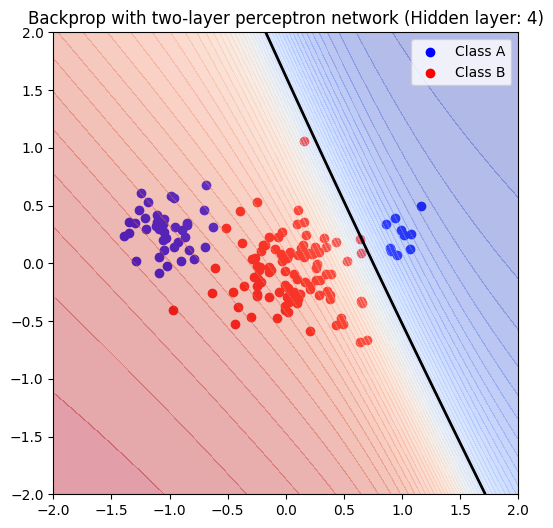

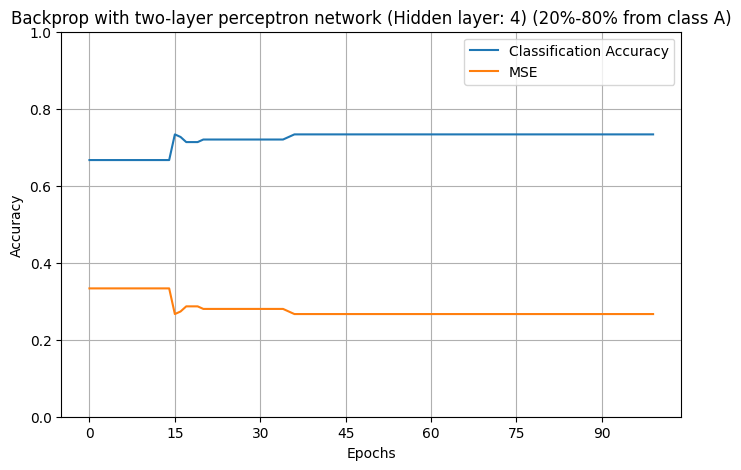

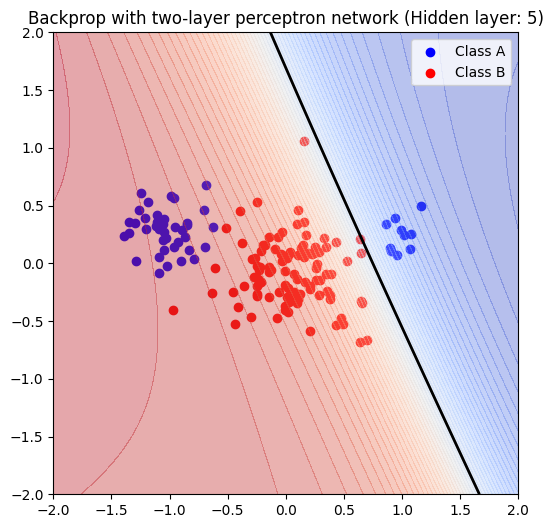

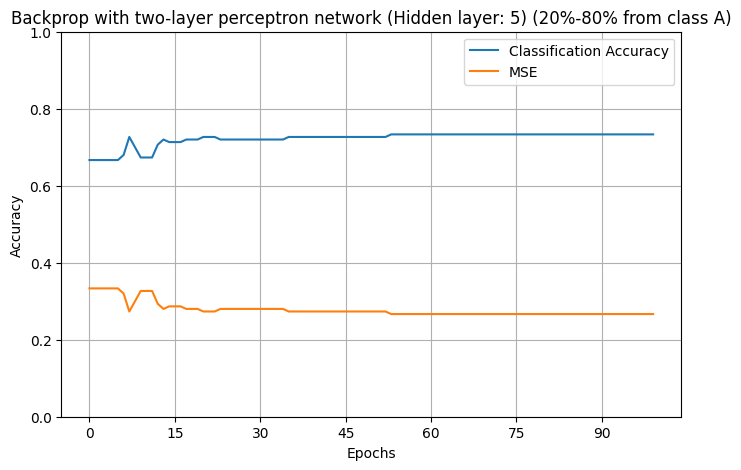

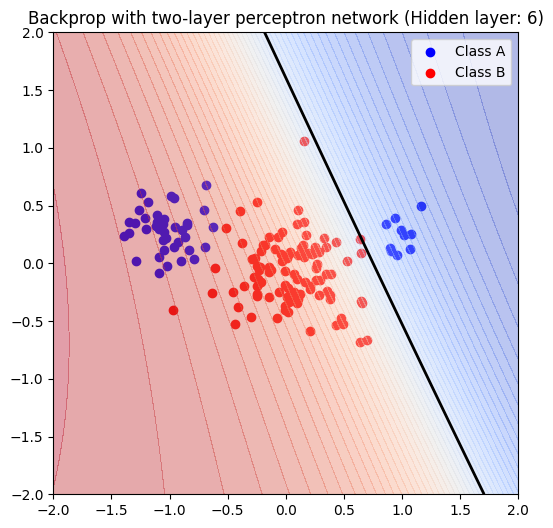

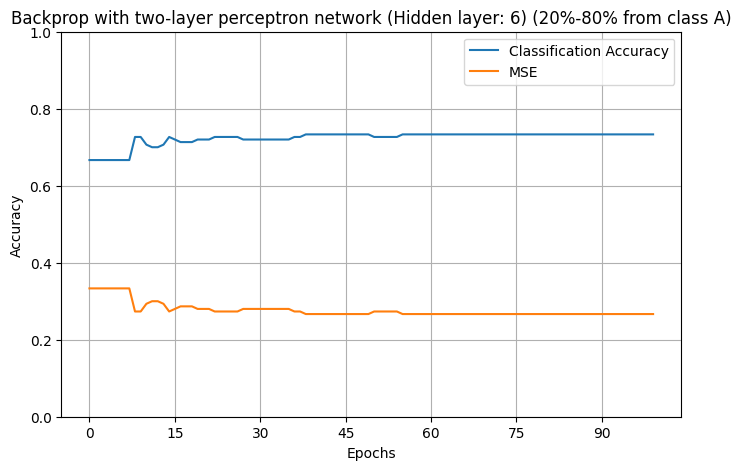

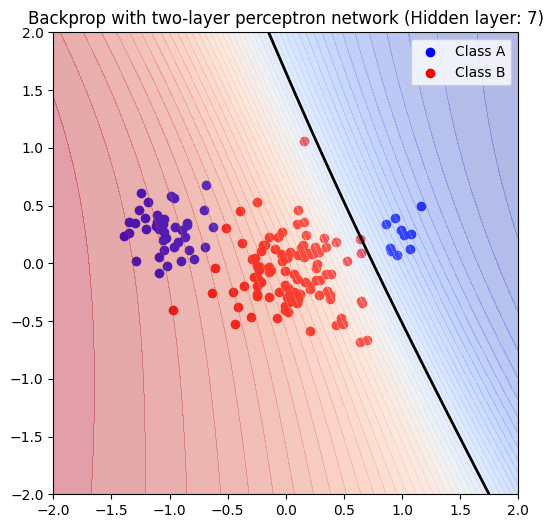

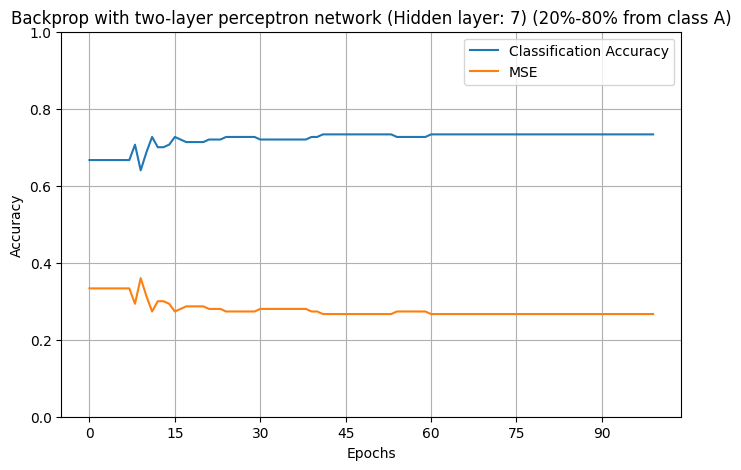

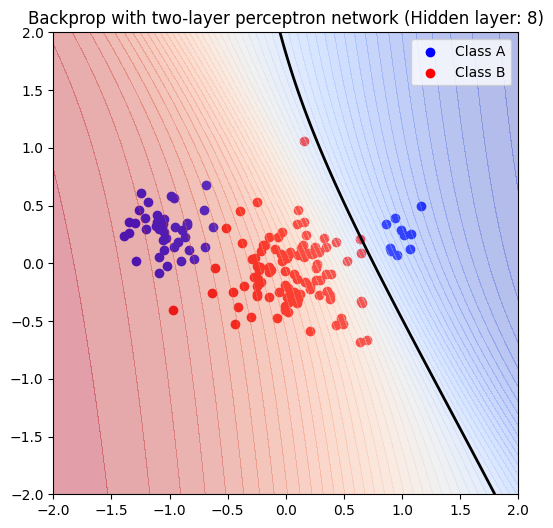

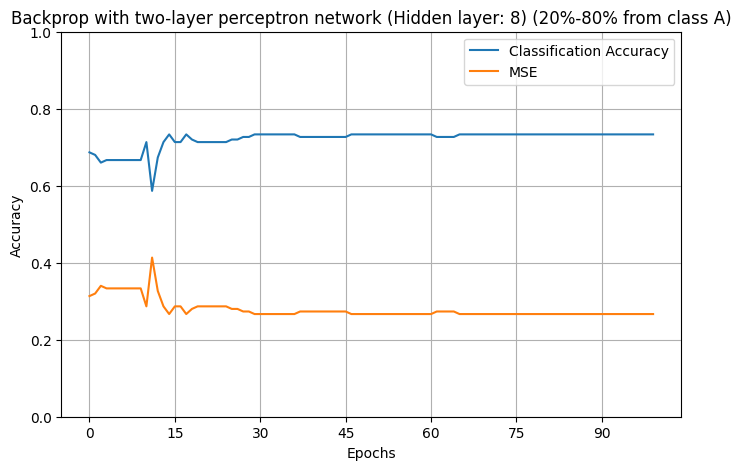

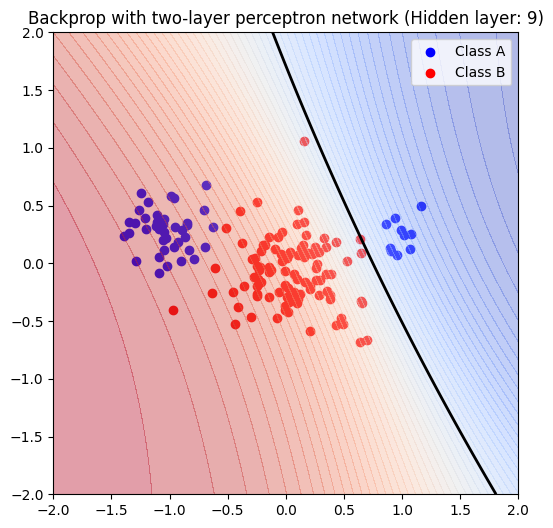

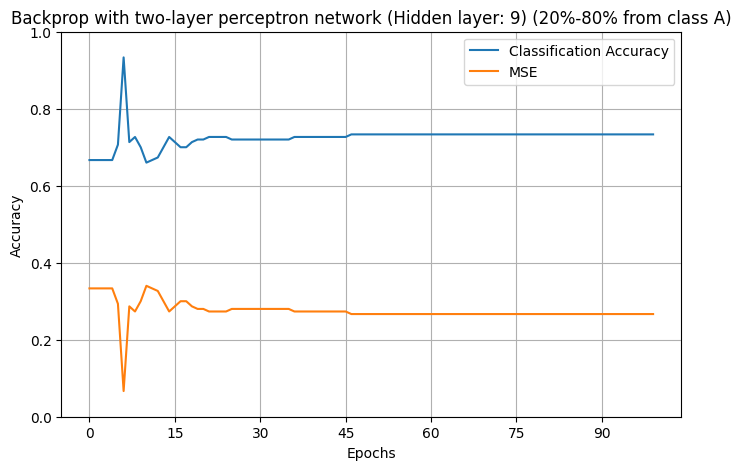

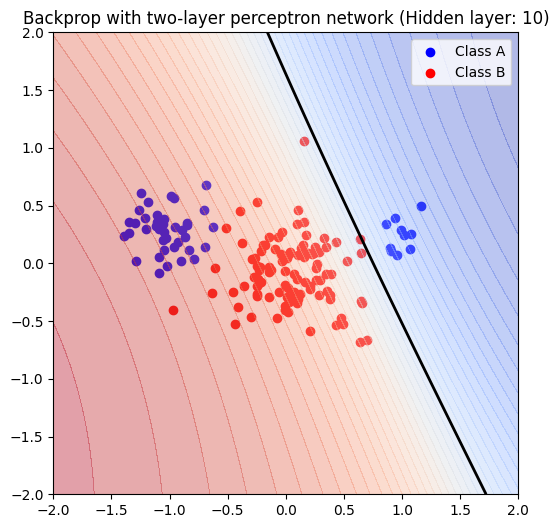

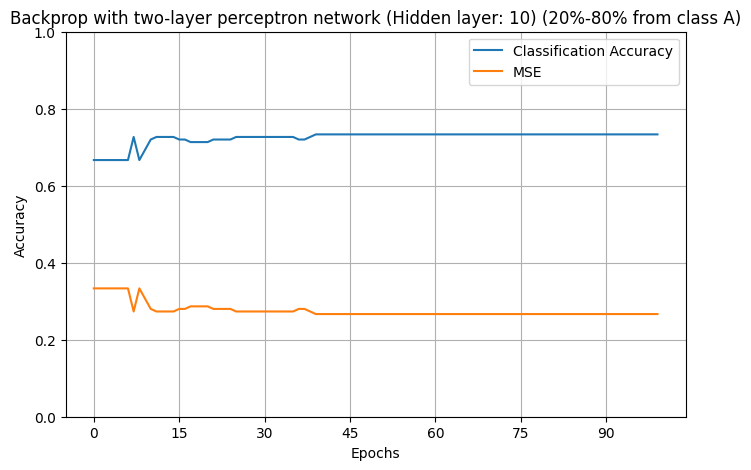

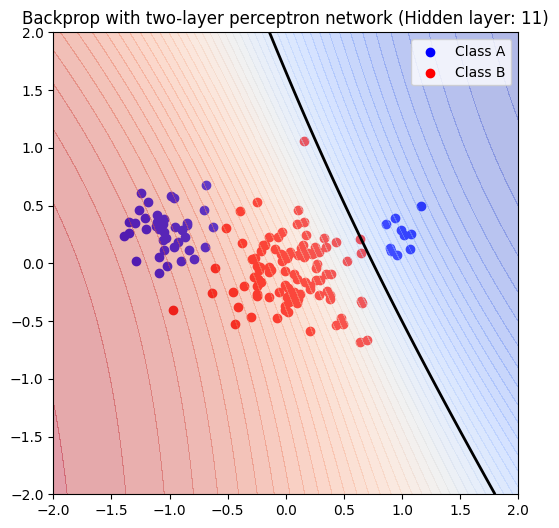

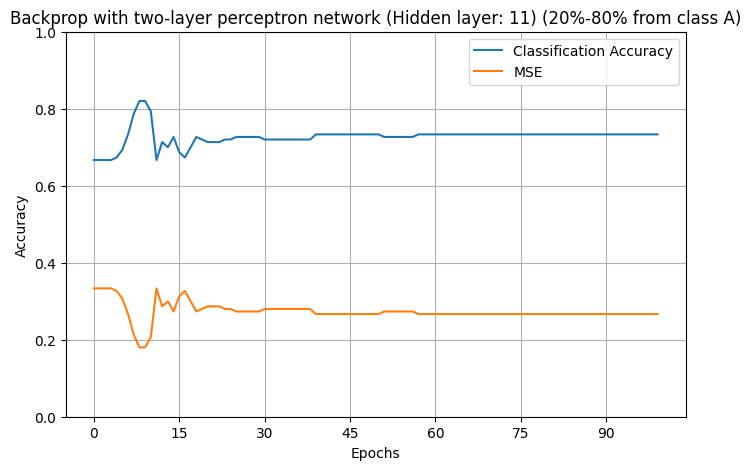

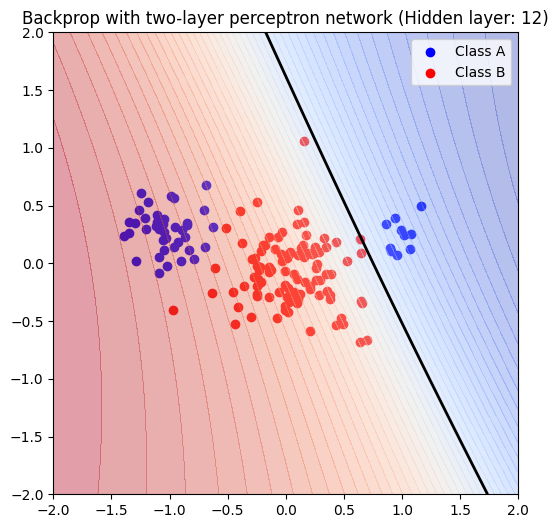

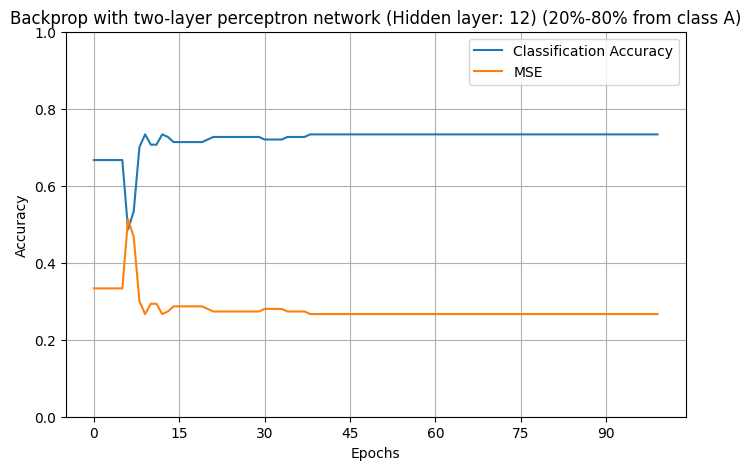

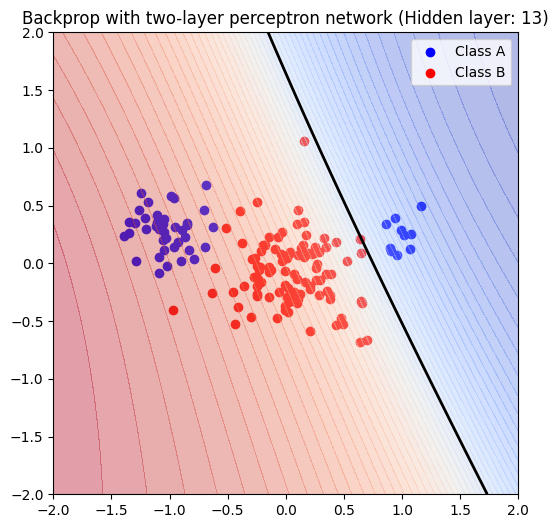

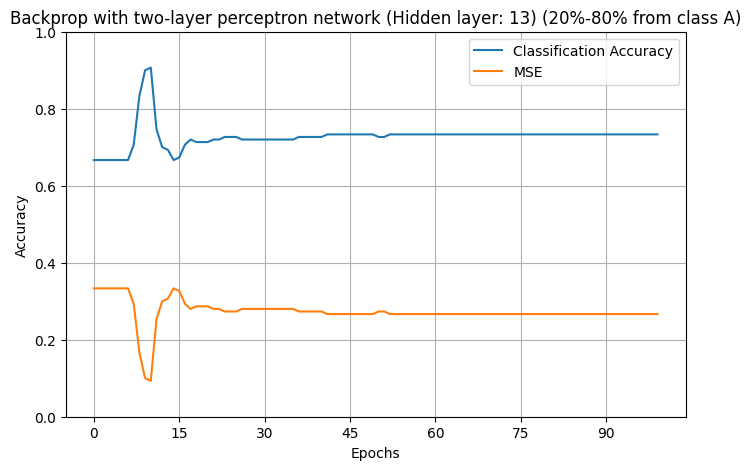

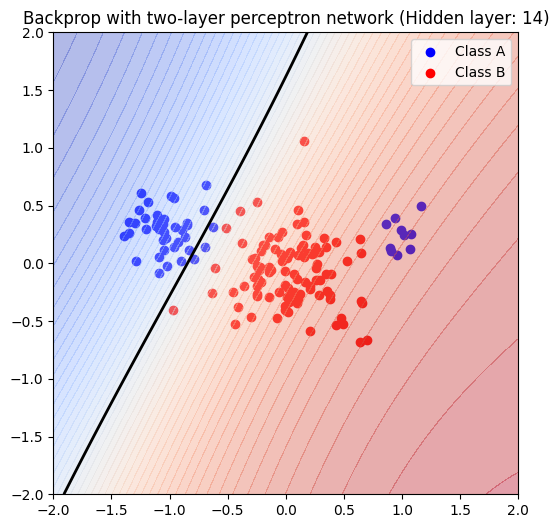

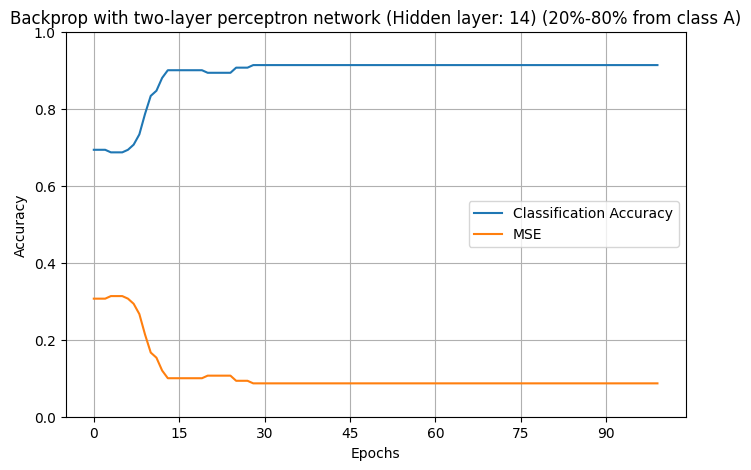

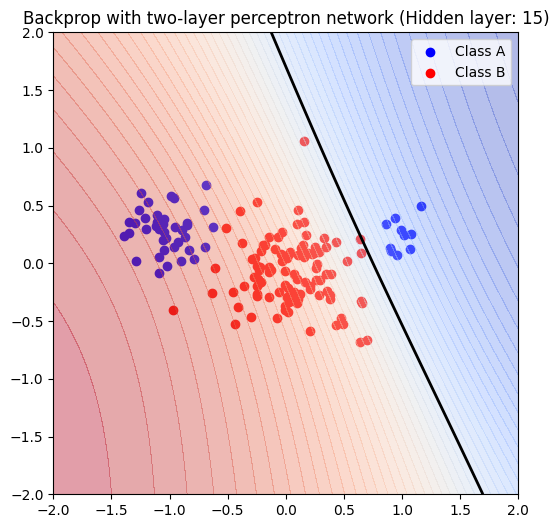

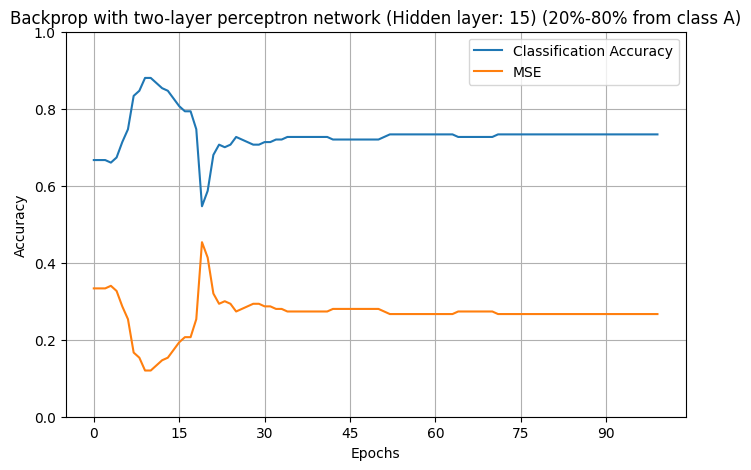

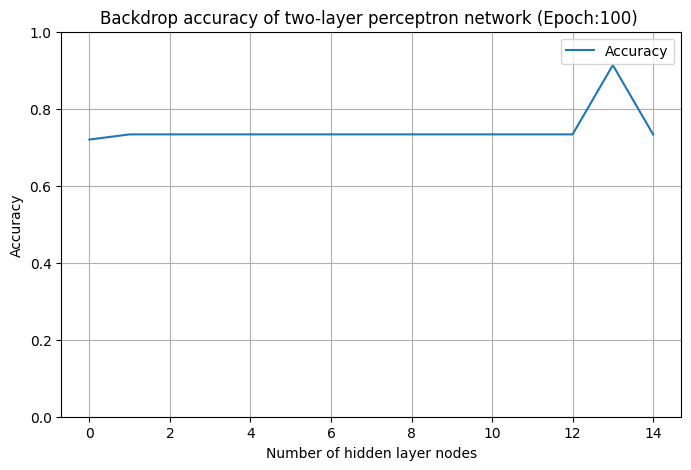

In [141]:
'''
Note that we manually split classA into two parts to regain the
old two groups where first half has mean at -1 and second half at +1.
Then we split those two halves into training and validation sets
with 20%-80% and combine them back together.
'''
classA_one_train, classA_one_val = split_data(classA[:int(np.round(0.5*n))], 0.20)
classA_two_train, classA_two_val = split_data(classA[int(np.round(0.5*n)):], 0.80)
classA_train = np.vstack((classA_one_train, classA_two_train))
classA_val = np.vstack((classA_one_val, classA_two_val))
classB_train = classB
classB_val = classB
print("classA_train.shape:", classA_train.shape)
print("classA_val.shape:", classA_val.shape)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(20%-80% from class A)')

Left off at question 2 under 3.1.1:

Is there any difference between a batch and sequential learning ap-
proach in terms of the validation performance?

But double check the 20%/80% scenario first!